#Imports

In [447]:
import json
import pandas as pd
from scipy.stats import spearmanr
import requests
import io
from urllib.request import urlopen
import json
import logging
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pandas.io.json import json_normalize
from pprint import pprint
from scipy.stats import shapiro
import scipy as sp
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import mannwhitneyu
from scipy.stats import linregress
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re

In [448]:
# installing mne for the BH correction
!pip install mne
import mne

!pip install scikit_posthocs
import scikit_posthocs as sp

!pip install pingouin
import pingouin as pg

!pip install statannotations
from statannotations.Annotator import Annotator



# Load files

In [449]:
df = pd.read_csv('/content/df_cleaned.csv')
#df = pd.read_csv('drive/MyDrive/MA_XAI/df_cleaned.csv')

df_journos = pd.read_csv('/content/cleaned_journos.csv')
#df_journos = pd.read_csv('drive/MyDrive/MA_XAI/cleaned_journos.csv')

df['METADATA.FEATURE'] = df['METADATA.FEATURE'].replace('explanations', 'free-text')
df_journos['METADATA.FEATURE'] = df_journos['METADATA.FEATURE'].replace('explanations', 'free-text')


# functions

In [450]:
# function to calculate Cohen's d for independent samples
def cohend(d1, d2):
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)

    # calculate the variance of the samples
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)

    # calculate the pooled standard deviation
    s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = np.mean(d1), np.mean(d2)

    # calculate the effect size
    return (u1 - u2) / s


In [451]:
def agrees_with_ai(row, newsitem_id):
    ai_rating = newsitems[newsitems["id"] == newsitem_id]["truthfulness"].values[0]
    human_rating = row[f"newsitem.{newsitem_id}.rating-before-xai"]
    return (human_rating < 50) == (ai_rating < 50)


## Define Kruskal Walis

In [452]:
import numpy as np
import scipy.stats as stats
import scikit_posthocs as sp

def perform_kruskal_wallis(df, columns, feature_value, print_results=False):
    if print_results:
        print("Columns:", columns)

    if feature_value != 'all':
        # Filter the dataframe based on METADATA.FEATURE value
        df = df[df['METADATA.FEATURE'] == feature_value]

    # Extract the column values as separate arrays
    data = [df[col].values for col in columns]

    # Perform Kruskal-Wallis test
    kruskal_result = stats.kruskal(*data)

    # Perform posthoc test
    posthoc_result = sp.posthoc_dunn(data)

    if print_results:
        print("Kruskal-Wallis Test:")
        print(kruskal_result)
        print("\nPosthoc Test:")
        print(posthoc_result)

    return kruskal_result, posthoc_result, df

## Define Kruskal-Wallis test function

In [453]:
def perform_kruskal_with_posthoc(df, col, print_results=True, between="METADATA.FEATURE"):
    if print_results:
        print("Column name:", col)

    kruskal_test = pg.kruskal(df, dv=col, between=between, detailed=True)
    kruskal_pval = kruskal_test["p-unc"].values[0]

    if print_results:
        print("kruskal_pval", kruskal_pval, "\n")


    # uses Mann–Whitney U test under the hood
    posthoc = pg.pairwise_tests(df, dv=col, between=between, parametric=False, padjust="holm")

    # print stuff if p-corr is smaller than 0.05 in all the comparisons
    if print_results:
        print(posthoc, "\n")

    if print_results:
        print(df.groupby(between)[col].describe()[["mean", "std"]], "\n")

    return kruskal_test, posthoc, df.groupby(between)[col].describe()

In [454]:
#calculate_alpha for constructs
def calculate_alpha(df):
    return pg.cronbach_alpha(data=df)


In [455]:
def find_highest_alpha(data):
    alpha_values = {}

    # Iterate over each item and calculate the alpha value by omitting the item
    for item in data.columns:
        items_without_current = data.drop(item, axis=1)  # DataFrame ohne das aktuelle Item
        alpha = pg.cronbach_alpha(data=items_without_current) # Alpha-Wert berechnen
        alpha_values[item] = alpha  # Alpha-Wert in das Dictionary speichern

    # Find the item that should be removed to achieve the highest alpha value
    max_alpha_item = max(alpha_values, key=alpha_values.get)
    max_alpha = alpha_values[max_alpha_item]

    return max_alpha_item, max_alpha

In [456]:
def calculate_stats(df):
    results = []
    for column in df.columns:
        shapiro_test = shapiro(df[column])
        mean = df[column].mean()
        median = df[column].median()
        results.append((column, shapiro_test.statistic, shapiro_test.pvalue, mean, median))

    # Create a DataFrame with the results
    df_results = pd.DataFrame(results, columns=['Column', 'Shapiro-Wilk', 'p-value', 'Mean', 'Median'])
    if shapiro_test.pvalue <= 0.05:
      print('no normal distribution since p value below 0.05')
    else:
      print('normal distribution since p value higher than 0.05')

    return df_results


In [457]:
def perform_kruskal_posthoc_multi(df, columns):
    # Create a new DataFrame to store the mean values
    kruskal_result = pg.kruskal(data=df[columns], dv=None, between='group')
    print(data)

    # Perform post-hoc Dunn's test
    posthoc_result = pg.pairwise_dunn(data=df[columns], dv=None, between='group')

    return kruskal_result, posthoc_result


## Define Spearmen Correlation Multi

In [458]:
def perform_spearman_corr(df, columns, feature_value, print_results=False):
    if print_results:
        print("Columns:", columns)

    if (feature_value != 'all'):
    # Filter the dataframe based on METADATA.FEATURE value
        df = df[df['METADATA.FEATURE'] == feature_value]

    # Calculate Spearman correlation matrix
    corr_matrix = df[columns].corr(method='spearman')

    if print_results:
        print("Spearman Correlation Matrix:")
        print(corr_matrix, "\n")

    # Perform post-hoc tests with FDR correction
    posthoc_results = pg.pairwise_corr(df, columns=columns, method='spearman', padjust='fdr_bh')
    modi_df = df

    if print_results:
        print("Post-hoc Tests:")
        print(posthoc_results, "\n")

    return corr_matrix, posthoc_results, modi_df



## Define Spearmen correlation between 2 vars

In [459]:
import scipy.stats as stats

def calculate_spearman_correlation(df, col1, col2):
    # Extract the two columns from the DataFrame
    data1 = df[col1]
    data2 = df[col2]

    # Calculate the Spearman correlation
    correlation, p_value = stats.spearmanr(data1, data2)
    print('Correlation: ', correlation)
    print('p_value: ', p_value)

    return correlation, p_value


##Define Regression analysis 2 var

In [460]:
def nonparametric_regression(df, version, x_column, y_column, save_path=None):
    # Perform the nonparametric regression

    if version != 'all':
        # Filter the dataframe based on METADATA.FEATURE value
        df = df[df['METADATA.FEATURE'] == version]

    df['constant'] = 1

    # Fit the non-parametric regression model
    model = sm.OLS(df[y_column], df[[x_column, 'constant']])
    results = model.fit()

    # Print the summary of regression results
    print(results.summary())



##Define Mann-Whitney-U test

In [461]:
def compare_laymen_journos(df_journos, df, construct, feature):
    results = []

    if feature:
        features = df_journos['METADATA.FEATURE'].unique()
        for feature in features:
            journos_values = df_journos[df_journos['METADATA.FEATURE'] == feature][construct]
            values = df[df['METADATA.FEATURE'] == feature][construct]
            statistic, p_value = mannwhitneyu(journos_values, values)
            results.append({'Feature': feature, 'Statistic': statistic, 'p-value': p_value})
    else:
        journos_values = df_journos[construct]
        values = df[construct]
        statistic, p_value = mannwhitneyu(journos_values, values)
        results.append({'Statistic': statistic, 'p-value': p_value})

    results_df = pd.DataFrame(results)
    return results_df

# News items

In [464]:
#newsitems = pd.read_csv('drive/MyDrive/MA_XAI/news-items.csv')
newsitems = pd.read_csv('/content/news-items.csv')

newsitems["id"] = newsitems.index + 1
newsitems.index = newsitems.index + 1

In [465]:
# only keep the relevant columns
newsitems = newsitems[["id", "label", "group",
                   "title", "subtitle", "content",
                     "source", "publishing_date", "category",
                   "highlighted_content", "truthfulness", "readability","natural_language_explanation",
                    "is_false_positive", "is_true_negative", "is_qualification"]]

In [466]:
# only keep newsitems from group 2 and newsitems without a group (FP and TN),
# since only these are used in the experiment
newsitems = newsitems[(newsitems["group"] == 2) | newsitems["group"].isna()]
newsitems = newsitems.drop(columns=["group"])

In [467]:
# create a new column, "is_fake_news", based on if "label" is "FAKE" or "TRUE"
newsitems["is_fake_news"] = newsitems["label"].apply(lambda x: True if x == "FAKE" else False)
newsitems = newsitems.drop(columns=["label"])

In [468]:
# remove percentage sign from truthfulness and convert to int
newsitems["truthfulness"] = newsitems["truthfulness"].apply(lambda x: int(x.replace("%", "")))

In [469]:
for i in range(7, 15):
  df[f"newsitem.{i}.agrees_with_ai"] = df.apply(lambda row: agrees_with_ai(row, i), axis=1)

In [470]:
for i in range(7, 15):
  df_journos[f"newsitem.{i}.agrees_with_ai"] = df_journos.apply(lambda row: agrees_with_ai(row, i), axis=1)

In [471]:
count_columns = df[['newsitem.7.agrees_with_ai', 'newsitem.8.agrees_with_ai', 'newsitem.9.agrees_with_ai', 'newsitem.10.agrees_with_ai', 'newsitem.11.agrees_with_ai', 'newsitem.12.agrees_with_ai']]
df['correct_human_detection'] = df[count_columns].sum(axis=1)

In [472]:
count_columns = df_journos[['newsitem.7.agrees_with_ai', 'newsitem.8.agrees_with_ai', 'newsitem.9.agrees_with_ai', 'newsitem.10.agrees_with_ai', 'newsitem.11.agrees_with_ai', 'newsitem.12.agrees_with_ai']]
df_journos['correct_human_detection'] = df_journos[count_columns].sum(axis=1)

# Cheater

In [473]:
df["METADATA.FEATURE"].value_counts()

salient      145
basic        142
free-text    141
Name: METADATA.FEATURE, dtype: int64

In [474]:
# participants who did not get 2 points in the qualification shouldn't be considered
df = df[df['POINTS.qualification'] == 2]
df = df[df["POINTS.main"] >= 5]
df["METADATA.FEATURE"].value_counts()


salient      140
basic        133
free-text    133
Name: METADATA.FEATURE, dtype: int64

# Mapping

In [475]:
media_outlet_mapping = {'online-newspaper': 6,
               'twitter': 8,
               'blogs-websites': 1,
               'newspaper': 5,
               'facebook': 2,
               'instagram': 3,
               'personal-social-networks': 7,
               'interview': 4}


df['most_used_source_numerical'] = df['information-seeking.most-used-sources.0'].map(media_outlet_mapping)

age_mapping = {
    '18-20': 1,
    '21-29': 2,
    '30-39': 3,
    '40-49': 4,
    '50-59': 5,
    '60-or-older': 6
}
df['age_numerical'] = df['demographics.age'].map(age_mapping)

df.dropna(subset=['age_numerical'], inplace=True)

df['age_numerical'].fillna(df['age_numerical'].mean(), inplace=True)

edu_mapping = {
    'university': 1,
    'high-school': 2,
    'no-degree': 3,
    'secondary': 4,
    'upper-secondary ': 5
}

df['edu_numerical'] = df['demographics.education'].map(edu_mapping)
df['edu_numerical'].fillna(df['edu_numerical'].mean(), inplace=True)

df['demographics.gender']

gender_mapping = {
    'female': 1,
    'male': 2,
    'diverse': 3
}
df['gender_numerical'] = df['demographics.gender'].map(gender_mapping)
df['gender_numerical'].fillna(df['gender_numerical'].mean(), inplace=True)

income_mapping = {
    'less-than-20000-usd': 1,
    'over-100000-usd': 2,
    '20000-34999-usd': 3,
    '35000-49999-usd':4,
    '50000-74999-usd':5,
    '75000-99999-usd':6,
    'no-answer': 7
}
df['income_numerical'] = df['demographics.income'].map(income_mapping)
df['income_numerical'].fillna(df['income_numerical'].mean(), inplace=True)



# Demographics


In [476]:
demographics_cols = [col for col in df.columns if col.startswith('demographics')]
demographics_cols

['demographics.age',
 'demographics.country',
 'demographics.education',
 'demographics.employment',
 'demographics.gender',
 'demographics.income',
 'demographics.nationality']

In [477]:
df["demographics.gender"].value_counts().sort_index()

diverse      3
female     258
male       145
Name: demographics.gender, dtype: int64

In [478]:
df_journos["demographics.gender"].value_counts().sort_index()

female    15
male      12
Name: demographics.gender, dtype: int64

In [479]:
df["demographics.age"].value_counts().sort_index()

18-20           16
21-29          105
30-39          156
40-49           93
50-59           28
60-or-older      8
Name: demographics.age, dtype: int64

In [480]:
df_journos["demographics.age"].value_counts().sort_index()

21-29           9
30-39          11
40-49           2
50-59           3
60-or-older     2
Name: demographics.age, dtype: int64

In [481]:
df["demographics.education"].value_counts().sort_index()

high-school        161
no-degree           11
secondary            9
university         220
upper-secondary      5
Name: demographics.education, dtype: int64

In [482]:
df_journos["demographics.education"].value_counts().sort_index()

high-school         6
no-degree           1
university         19
upper-secondary     1
Name: demographics.education, dtype: int64

In [483]:
df["demographics.employment"].value_counts().sort_index()

apprentice             2
civil-servant          3
other                 26
retiree-pensioner      3
salaried-employee    148
self-employed        129
student               40
unemployed            55
Name: demographics.employment, dtype: int64

In [484]:
df_journos["demographics.employment"].value_counts().sort_index()

salaried-employee    21
self-employed         5
student               1
Name: demographics.employment, dtype: int64

In [485]:
df["demographics.income"].value_counts().sort_index()

20000-34999-usd        72
35000-49999-usd        44
50000-74999-usd        83
75000-99999-usd        49
less-than-20000-usd    58
no-answer              45
over-100000-usd        55
Name: demographics.income, dtype: int64

In [486]:
df_journos["demographics.income"].value_counts().sort_index()

20000-34999-usd         4
35000-49999-usd        11
50000-74999-usd         3
75000-99999-usd         1
less-than-20000-usd     2
no-answer               4
over-100000-usd         2
Name: demographics.income, dtype: int64

In [487]:
df_journos["METADATA.FEATURE"].value_counts().sort_index()

basic         7
free-text    10
salient      10
Name: METADATA.FEATURE, dtype: int64

#Prepare Categories

### Understandability

In [488]:
#Understandability global
df[['news-dashboard-evaluation.comprehensible-explanations-help-assess-news-articles',
'news-dashboard-evaluation.complicated-explainability-features',
'news-dashboard-evaluation.comprehensible-useful-metadata']]
#reverse coded question
df['news-dashboard-evaluation.complicated-explainability-features'] = 8 - df['news-dashboard-evaluation.complicated-explainability-features']


In [489]:
calculate_alpha(df[['news-dashboard-evaluation.comprehensible-explanations-help-assess-news-articles',
'news-dashboard-evaluation.complicated-explainability-features',
'news-dashboard-evaluation.comprehensible-useful-metadata']])

(0.3518626718798052, array([0.234, 0.454]))

In [490]:
find_highest_alpha(df[['news-dashboard-evaluation.comprehensible-explanations-help-assess-news-articles',
'news-dashboard-evaluation.complicated-explainability-features',
'news-dashboard-evaluation.comprehensible-useful-metadata']])

('news-dashboard-evaluation.complicated-explainability-features',
 (0.705091760751607, array([0.642, 0.757])))

In [491]:
df.drop(['news-dashboard-evaluation.complicated-explainability-features'], axis=1, inplace=True)
calculate_alpha(df[['news-dashboard-evaluation.comprehensible-explanations-help-assess-news-articles',
'news-dashboard-evaluation.comprehensible-useful-metadata']])

(0.705091760751607, array([0.642, 0.757]))

In [492]:
#mean global per participant
df['understandability_overall_global'] = df[['news-dashboard-evaluation.comprehensible-explanations-help-assess-news-articles', 'news-dashboard-evaluation.comprehensible-useful-metadata']].mean(axis=1)
#mean local per paricipant
df['understandability_overall_local'] = df[['newsitem.7.system-evaluation.explanations-comprehensible-and-help-assess',
                                            'newsitem.8.system-evaluation.explanations-comprehensible-and-help-assess',
    'newsitem.9.system-evaluation.explanations-comprehensible-and-help-assess',
    'newsitem.10.system-evaluation.explanations-comprehensible-and-help-assess',
    'newsitem.11.system-evaluation.explanations-comprehensible-and-help-assess',
    'newsitem.12.system-evaluation.explanations-comprehensible-and-help-assess',
]].mean(axis=1)

df_journos['understandability_overall_local'] = df_journos[['newsitem.7.system-evaluation.explanations-comprehensible-and-help-assess',
                                                    'newsitem.8.system-evaluation.explanations-comprehensible-and-help-assess',
    'newsitem.9.system-evaluation.explanations-comprehensible-and-help-assess',
    'newsitem.10.system-evaluation.explanations-comprehensible-and-help-assess',
    'newsitem.11.system-evaluation.explanations-comprehensible-and-help-assess',
    'newsitem.12.system-evaluation.explanations-comprehensible-and-help-assess',
]].mean(axis=1)


df_journos['understandability_overall_global'] = df_journos[['news-dashboard-evaluation.comprehensible-explanations-help-assess-news-articles', 'news-dashboard-evaluation.comprehensible-useful-metadata']].mean(axis=1)

In [493]:
calculate_alpha(df[['newsitem.7.system-evaluation.explanations-comprehensible-and-help-assess',
                                            'newsitem.8.system-evaluation.explanations-comprehensible-and-help-assess',
    'newsitem.9.system-evaluation.explanations-comprehensible-and-help-assess',
    'newsitem.10.system-evaluation.explanations-comprehensible-and-help-assess',
    'newsitem.11.system-evaluation.explanations-comprehensible-and-help-assess',
    'newsitem.12.system-evaluation.explanations-comprehensible-and-help-assess',
]])

(0.8598056349135119, array([0.838, 0.88 ]))

In [494]:
calculate_stats(df[df['METADATA.FEATURE'] == 'basic'][['understandability_overall_global']])


no normal distribution since p value below 0.05


,Column,Shapiro-Wilk,p-value,Mean,Median
0,understandability_overall_global,0.944535,0.000036,5.315789,5.5


In [495]:
calculate_stats(df[df['METADATA.FEATURE'] == 'salient'][['understandability_overall_global']])


no normal distribution since p value below 0.05


,Column,Shapiro-Wilk,p-value,Mean,Median
0,understandability_overall_global,0.911584,1.433459e-07,5.364286,5.5


In [496]:
calculate_stats(df[df['METADATA.FEATURE'] == 'free-text'][['understandability_overall_global']])


no normal distribution since p value below 0.05


,Column,Shapiro-Wilk,p-value,Mean,Median
0,understandability_overall_global,0.910715,2.307556e-07,5.616541,6.0


In [497]:
calculate_stats(df[df['METADATA.FEATURE'] == 'basic'][['understandability_overall_local']])


no normal distribution since p value below 0.05


,Column,Shapiro-Wilk,p-value,Mean,Median
0,understandability_overall_local,0.916184,4.810065e-07,5.923559,6.0


In [498]:
calculate_stats(df[df['METADATA.FEATURE'] == 'salient'][['understandability_overall_local']])


no normal distribution since p value below 0.05


,Column,Shapiro-Wilk,p-value,Mean,Median
0,understandability_overall_local,0.89365,1.435235e-08,6.210714,6.333333


In [499]:
calculate_stats(df[df['METADATA.FEATURE'] == 'free-text'][['understandability_overall_local']])


no normal distribution since p value below 0.05


,Column,Shapiro-Wilk,p-value,Mean,Median
0,understandability_overall_local,0.73274,2.922079e-14,6.353383,6.666667


### Trust

In [500]:
#Trust global
calculate_alpha(df[['ai-system-evaluation.system-supports-decision-making',
                'ai-system-evaluation.system-able-to-classify-news-articles',
                'ai-system-evaluation.system-can-correctly-classify-news-articles',
                'ai-system-evaluation.system-can-efficiently-classify-news-articles',
                'ai-system-evaluation.system-able-to-detect-fake-news',
                'ai-system-evaluation.system-decides-neutral',
'ai-system-evaluation.system-decides-consistently',
'ai-system-evaluation.system-criteria-acceptable',
'ai-system-evaluation.understand-why-system-provided-decision',
'ai-system-evaluation.understand-what-system-bases-decision-on',
'ai-system-evaluation.classification-comprehensible',
'ai-system-evaluation.easy-to-follow-what-system-does',
'news-dashboard-evaluation.satisfied-with-explanatory-quality',
'ai-system-evaluation.know-what-will-happen-next-time',
'ai-system-evaluation.tend-to-trust-system-even-without-knowledge',
'ai-system-evaluation.tendency-to-trust-system-high']])

(0.9521963326348143, array([0.945, 0.959]))

In [501]:
#mean global per participant
df['trust_overall_global'] = df[['ai-system-evaluation.system-supports-decision-making',
                'ai-system-evaluation.system-able-to-classify-news-articles',
                'ai-system-evaluation.system-can-correctly-classify-news-articles',
                'ai-system-evaluation.system-can-efficiently-classify-news-articles',
                'ai-system-evaluation.system-able-to-detect-fake-news',
                'ai-system-evaluation.system-decides-neutral',
'ai-system-evaluation.system-decides-consistently',
'ai-system-evaluation.system-criteria-acceptable',
'ai-system-evaluation.understand-why-system-provided-decision',
'ai-system-evaluation.understand-what-system-bases-decision-on',
'ai-system-evaluation.classification-comprehensible',
'ai-system-evaluation.easy-to-follow-what-system-does',
'news-dashboard-evaluation.satisfied-with-explanatory-quality',
'ai-system-evaluation.know-what-will-happen-next-time',
'ai-system-evaluation.tend-to-trust-system-even-without-knowledge',
'ai-system-evaluation.tendency-to-trust-system-high']].mean(axis=1)

#mean global per participant
df_journos['trust_overall_global'] = df_journos[['ai-system-evaluation.system-supports-decision-making',
                'ai-system-evaluation.system-able-to-classify-news-articles',
                'ai-system-evaluation.system-can-correctly-classify-news-articles',
                'ai-system-evaluation.system-can-efficiently-classify-news-articles',
                'ai-system-evaluation.system-able-to-detect-fake-news',
                'ai-system-evaluation.system-decides-neutral',
'ai-system-evaluation.system-decides-consistently',
'ai-system-evaluation.system-criteria-acceptable',
'ai-system-evaluation.understand-why-system-provided-decision',
'ai-system-evaluation.understand-what-system-bases-decision-on',
'ai-system-evaluation.classification-comprehensible',
'ai-system-evaluation.easy-to-follow-what-system-does',
'news-dashboard-evaluation.satisfied-with-explanatory-quality',
'ai-system-evaluation.know-what-will-happen-next-time',
'ai-system-evaluation.tend-to-trust-system-even-without-knowledge',
'ai-system-evaluation.tendency-to-trust-system-high']].mean(axis=1)


In [502]:
#Trust localdf[['newsitem.8.system-evaluation.explanations-comprehensible-and-help-assess',
df['trust_overall_local'] = df[['newsitem.7.system-evaluation.classified-correctly',
  'newsitem.7.system-evaluation.understand-what-system-does',
  'newsitem.8.system-evaluation.classified-correctly',
  'newsitem.8.system-evaluation.understand-what-system-does',
  'newsitem.9.system-evaluation.classified-correctly',
  'newsitem.9.system-evaluation.understand-what-system-does',
  'newsitem.10.system-evaluation.classified-correctly',
  'newsitem.10.system-evaluation.understand-what-system-does',
  'newsitem.11.system-evaluation.classified-correctly',
  'newsitem.11.system-evaluation.understand-what-system-does',
  'newsitem.12.system-evaluation.classified-correctly',
  'newsitem.12.system-evaluation.understand-what-system-does',
  ]].mean(axis=1)

#Trust localdf[['newsitem.8.system-evaluation.explanations-comprehensible-and-help-assess',
df_journos['trust_overall_local'] = df_journos[['newsitem.7.system-evaluation.classified-correctly',
  'newsitem.7.system-evaluation.understand-what-system-does',
  'newsitem.8.system-evaluation.classified-correctly',
  'newsitem.8.system-evaluation.understand-what-system-does',
  'newsitem.9.system-evaluation.classified-correctly',
  'newsitem.9.system-evaluation.understand-what-system-does',
  'newsitem.10.system-evaluation.classified-correctly',
  'newsitem.10.system-evaluation.understand-what-system-does',
  'newsitem.11.system-evaluation.classified-correctly',
  'newsitem.11.system-evaluation.understand-what-system-does',
  'newsitem.12.system-evaluation.classified-correctly',
  'newsitem.12.system-evaluation.understand-what-system-does',
  ]].mean(axis=1)



In [503]:
calculate_alpha(df[['newsitem.7.system-evaluation.classified-correctly',
  'newsitem.7.system-evaluation.understand-what-system-does',
  'newsitem.8.system-evaluation.classified-correctly',
  'newsitem.8.system-evaluation.understand-what-system-does',
  'newsitem.9.system-evaluation.classified-correctly',
  'newsitem.9.system-evaluation.understand-what-system-does',
  'newsitem.10.system-evaluation.classified-correctly',
  'newsitem.10.system-evaluation.understand-what-system-does',
  'newsitem.11.system-evaluation.classified-correctly',
  'newsitem.11.system-evaluation.understand-what-system-does',
  'newsitem.12.system-evaluation.classified-correctly',
  'newsitem.12.system-evaluation.understand-what-system-does',
  ]])

(0.834930899915255, array([0.81 , 0.858]))

In [504]:
calculate_stats(df[df['METADATA.FEATURE'] == 'basic'][['trust_overall_global']])


normal distribution since p value higher than 0.05


,Column,Shapiro-Wilk,p-value,Mean,Median
0,trust_overall_global,0.986527,0.217276,4.828947,4.875


In [505]:
calculate_stats(df[df['METADATA.FEATURE'] == 'salient'][['trust_overall_global']])


no normal distribution since p value below 0.05


,Column,Shapiro-Wilk,p-value,Mean,Median
0,trust_overall_global,0.952158,0.00009,5.130804,5.375


In [506]:
calculate_stats(df[df['METADATA.FEATURE'] == 'free-text'][['trust_overall_global']])


no normal distribution since p value below 0.05


,Column,Shapiro-Wilk,p-value,Mean,Median
0,trust_overall_global,0.962979,0.001112,5.25,5.25


In [507]:
calculate_stats(df[df['METADATA.FEATURE'] == 'basic'][['trust_overall_local']])


no normal distribution since p value below 0.05


,Column,Shapiro-Wilk,p-value,Mean,Median
0,trust_overall_local,0.958509,0.000458,6.070175,6.166667


In [508]:
calculate_stats(df[df['METADATA.FEATURE'] == 'salient'][['trust_overall_local']])


no normal distribution since p value below 0.05


,Column,Shapiro-Wilk,p-value,Mean,Median
0,trust_overall_local,0.903319,4.807967e-08,6.242857,6.333333


In [509]:
calculate_stats(df[df['METADATA.FEATURE'] == 'free-text'][['trust_overall_local']])


no normal distribution since p value below 0.05


,Column,Shapiro-Wilk,p-value,Mean,Median
0,trust_overall_local,0.880886,6.315123e-09,6.350251,6.5


###Explainability Usefulness

In [510]:
#global
df[['news-dashboard-evaluation.increase-effectiveness-fake-news-detection',
'news-dashboard-evaluation.useful-assess-news-articles',
'news-dashboard-evaluation.help-detect-fake-news-faster',
'news-dashboard-evaluation.assist-decisions',
'news-dashboard-evaluation.useful-explanations-news',
'news-dashboard-evaluation.long-learning-time-not-worth'
]]
#reverse coded
df['news-dashboard-evaluation.long-learning-time-not-worth'] = 8 - df['news-dashboard-evaluation.long-learning-time-not-worth']

#global
df_journos[['news-dashboard-evaluation.increase-effectiveness-fake-news-detection',
'news-dashboard-evaluation.useful-assess-news-articles',
'news-dashboard-evaluation.help-detect-fake-news-faster',
'news-dashboard-evaluation.assist-decisions',
'news-dashboard-evaluation.useful-explanations-news',
'news-dashboard-evaluation.long-learning-time-not-worth'
]]
#reverse coded
df_journos['news-dashboard-evaluation.long-learning-time-not-worth'] = 8 - df_journos['news-dashboard-evaluation.long-learning-time-not-worth']


In [511]:
calculate_alpha(df[['news-dashboard-evaluation.increase-effectiveness-fake-news-detection',
'news-dashboard-evaluation.useful-assess-news-articles',
'news-dashboard-evaluation.help-detect-fake-news-faster',
'news-dashboard-evaluation.assist-decisions',
'news-dashboard-evaluation.useful-explanations-news',
'news-dashboard-evaluation.long-learning-time-not-worth'
]])

(0.8232719449492394, array([0.795, 0.849]))

In [512]:
#mean global
df['usefulness_overall_global'] = df[['news-dashboard-evaluation.increase-effectiveness-fake-news-detection',
'news-dashboard-evaluation.useful-assess-news-articles',
'news-dashboard-evaluation.help-detect-fake-news-faster',
'news-dashboard-evaluation.assist-decisions',
'news-dashboard-evaluation.useful-explanations-news',
'news-dashboard-evaluation.long-learning-time-not-worth'
]].mean(axis=1)

df_journos['usefulness_overall_global'] = df_journos[['news-dashboard-evaluation.increase-effectiveness-fake-news-detection',
'news-dashboard-evaluation.useful-assess-news-articles',
'news-dashboard-evaluation.help-detect-fake-news-faster',
'news-dashboard-evaluation.assist-decisions',
'news-dashboard-evaluation.useful-explanations-news',
'news-dashboard-evaluation.long-learning-time-not-worth'
]].mean(axis=1)

In [513]:
df['usefulness_overall_local']=df[['newsitem.7.system-evaluation.indications-useful',
    'newsitem.7.system-evaluation.xai-features-useful',
    'newsitem.8.system-evaluation.indications-useful',
    'newsitem.8.system-evaluation.xai-features-useful',
    'newsitem.9.system-evaluation.indications-useful',
    'newsitem.9.system-evaluation.xai-features-useful',
    'newsitem.10.system-evaluation.indications-useful',
    'newsitem.10.system-evaluation.xai-features-useful',
    'newsitem.11.system-evaluation.indications-useful',
    'newsitem.11.system-evaluation.xai-features-useful',
    'newsitem.12.system-evaluation.indications-useful',
    'newsitem.12.system-evaluation.xai-features-useful',
]].mean(axis=1)


df_journos['usefulness_overall_local']=df_journos[['newsitem.7.system-evaluation.indications-useful',
    'newsitem.7.system-evaluation.xai-features-useful',
    'newsitem.8.system-evaluation.indications-useful',
    'newsitem.8.system-evaluation.xai-features-useful',
    'newsitem.9.system-evaluation.indications-useful',
    'newsitem.9.system-evaluation.xai-features-useful',
    'newsitem.10.system-evaluation.indications-useful',
    'newsitem.10.system-evaluation.xai-features-useful',
    'newsitem.11.system-evaluation.indications-useful',
    'newsitem.11.system-evaluation.xai-features-useful',
    'newsitem.12.system-evaluation.indications-useful',
    'newsitem.12.system-evaluation.xai-features-useful',
]].mean(axis=1)

In [514]:
calculate_alpha(df[['newsitem.7.system-evaluation.indications-useful',
    'newsitem.7.system-evaluation.xai-features-useful',
    'newsitem.8.system-evaluation.indications-useful',
    'newsitem.8.system-evaluation.xai-features-useful',
    'newsitem.9.system-evaluation.indications-useful',
    'newsitem.9.system-evaluation.xai-features-useful',
    'newsitem.10.system-evaluation.indications-useful',
    'newsitem.10.system-evaluation.xai-features-useful',
    'newsitem.11.system-evaluation.indications-useful',
    'newsitem.11.system-evaluation.xai-features-useful',
    'newsitem.12.system-evaluation.indications-useful',
    'newsitem.12.system-evaluation.xai-features-useful',
]])

(0.9060480700947624, array([0.892, 0.919]))

### Information Literacy

In [515]:
calculate_alpha(df[['information-literacy.access-relevant-literature',
'information-literacy.check-reliability',
'information-literacy.differentiate-right-and-fake',
'information-literacy.efficiently-use-subscribed-and-openaccess',
'information-literacy.have-it-skills',
'information-literacy.identify-authentic-sources',
'information-literacy.identify-misinformation',
'information-literacy.plagiarism-and-publication-ethics',
'information-literacy.research-level-skilss'
]])

df['information_literacy_overall'] = df[['information-literacy.access-relevant-literature',
'information-literacy.check-reliability',
'information-literacy.differentiate-right-and-fake',
'information-literacy.efficiently-use-subscribed-and-openaccess',
'information-literacy.have-it-skills',
'information-literacy.identify-authentic-sources',
'information-literacy.identify-misinformation',
'information-literacy.plagiarism-and-publication-ethics',
'information-literacy.research-level-skilss'
]].mean(axis=1)

df_journos['information_literacy_overall'] = df_journos[['information-literacy.access-relevant-literature',
'information-literacy.check-reliability',
'information-literacy.differentiate-right-and-fake',
'information-literacy.efficiently-use-subscribed-and-openaccess',
'information-literacy.have-it-skills',
'information-literacy.identify-authentic-sources',
'information-literacy.identify-misinformation',
'information-literacy.plagiarism-and-publication-ethics',
'information-literacy.research-level-skilss'
]].mean(axis=1)

In [516]:
calculate_stats(df[df['METADATA.FEATURE'] == 'basic'][['usefulness_overall_global']])


no normal distribution since p value below 0.05


,Column,Shapiro-Wilk,p-value,Mean,Median
0,usefulness_overall_global,0.975649,0.017225,5.219298,5.333333


In [517]:
calculate_stats(df[df['METADATA.FEATURE'] == 'salient'][['usefulness_overall_global']])


no normal distribution since p value below 0.05


,Column,Shapiro-Wilk,p-value,Mean,Median
0,usefulness_overall_global,0.938994,0.000009,5.466667,5.666667


In [518]:
calculate_stats(df[df['METADATA.FEATURE'] == 'free-text'][['usefulness_overall_global']])


no normal distribution since p value below 0.05


,Column,Shapiro-Wilk,p-value,Mean,Median
0,usefulness_overall_global,0.947303,0.000058,5.665414,5.833333


In [519]:
calculate_stats(df[df['METADATA.FEATURE'] == 'basic'][['usefulness_overall_local']])


no normal distribution since p value below 0.05


,Column,Shapiro-Wilk,p-value,Mean,Median
0,usefulness_overall_local,0.939371,0.000015,5.906015,6.0


In [520]:
calculate_stats(df[df['METADATA.FEATURE'] == 'salient'][['usefulness_overall_local']])


no normal distribution since p value below 0.05


,Column,Shapiro-Wilk,p-value,Mean,Median
0,usefulness_overall_local,0.908709,9.737990e-08,6.128571,6.166667


In [521]:
calculate_stats(df[df['METADATA.FEATURE'] == 'free-text'][['usefulness_overall_local']])


no normal distribution since p value below 0.05


,Column,Shapiro-Wilk,p-value,Mean,Median
0,usefulness_overall_local,0.819763,1.747277e-11,6.281328,6.416667


## Expectations before AI

In [522]:
expectations_columns = [col for col in df.columns if col.startswith('expectations')]
df['expectations.sceptical-about-ai'] = 8 - df['expectations.sceptical-about-ai']
df_journos['expectations.sceptical-about-ai'] = 8 - df_journos['expectations.sceptical-about-ai']


In [523]:
calculate_alpha(df[expectations_columns])

(0.8175402757835462, array([0.788, 0.844]))

In [524]:
df['expectation_before_ai_overall']= df[expectations_columns].mean(axis=1)

df_journos['expectation_before_ai_overall']= df_journos[expectations_columns].mean(axis=1)


In [525]:
calculate_stats(df[expectations_columns])

no normal distribution since p value below 0.05


,Column,Shapiro-Wilk,p-value,Mean,Median
0,expectations.benefit-of-doubt,0.886746,1.000032e-16,5.229064,6.0
1,expectations.rely-on-ai-for-fake-news-detection,0.925618,2.579922e-13,4.729064,5.0
2,expectations.sceptical-about-ai,0.941562,1.499609e-11,3.669951,3.0
3,expectations.trust-ai,0.926401,3.104154e-13,4.640394,5.0
4,expectations.trust-new-tech,0.922495,1.249583e-13,4.682266,5.0


## Opinion after AI

In [526]:
df[['ai-system-evaluation.benefit-of-doubt',
    'ai-system-evaluation.rely-on-ai-system',
    'ai-system-evaluation.sceptical-about-ai-system',
    'ai-system-evaluation.trust-new-tech']]

df['ai-system-evaluation.sceptical-about-ai-system'] = 8 - df['ai-system-evaluation.sceptical-about-ai-system']


df_journos['ai-system-evaluation.sceptical-about-ai-system'] = 8 - df_journos['ai-system-evaluation.sceptical-about-ai-system']


In [527]:
calculate_alpha(df[[
    'ai-system-evaluation.benefit-of-doubt',
    'ai-system-evaluation.rely-on-ai-system',
    'ai-system-evaluation.sceptical-about-ai-system',
    'ai-system-evaluation.trust-new-tech']])


(0.7489491074088821, array([0.707, 0.787]))

In [528]:
df['expectations_after_ai_overall']= df[[
    'ai-system-evaluation.benefit-of-doubt',
    'ai-system-evaluation.rely-on-ai-system',
    'ai-system-evaluation.sceptical-about-ai-system',
    'ai-system-evaluation.trust-new-tech']].mean(axis=1)

df_journos['expectations_after_ai_overall']= df_journos[[
    'ai-system-evaluation.benefit-of-doubt',
    'ai-system-evaluation.rely-on-ai-system',
    'ai-system-evaluation.sceptical-about-ai-system',
    'ai-system-evaluation.trust-new-tech']].mean(axis=1)


# Accuracy
code from balazs

In [529]:
RATING_THRESHOLD = 50

newsitems["is_fake_news_pred"] = newsitems["truthfulness"] < RATING_THRESHOLD
newsitems["is_fake_news"].value_counts()

True     5
False    3
Name: is_fake_news, dtype: int64

In [530]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, brier_score_loss, log_loss

ai_accuracy = accuracy_score(newsitems["is_fake_news"], newsitems["is_fake_news_pred"])
ai_precision = precision_score(newsitems["is_fake_news"], newsitems["is_fake_news_pred"])
ai_recall = recall_score(newsitems["is_fake_news"], newsitems["is_fake_news_pred"])
ai_f1 = f1_score(newsitems["is_fake_news"], newsitems["is_fake_news_pred"])
ai_roc_auc = roc_auc_score(newsitems["is_fake_news"], 1 - (newsitems["truthfulness"] / 100))
ai_brier_score = brier_score_loss(
    newsitems["is_fake_news"],
    newsitems["truthfulness"] / 100,
    pos_label=0
)

ai_performance_df = pd.DataFrame({
  "accuracy": [ai_accuracy],
  "precision": [ai_precision],
  "recall": [ai_recall],
  "f1": [ai_f1],
  "roc_auc_score": [ai_roc_auc],
  "brier_score": [ai_brier_score]
})

ai_performance_df

,accuracy,precision,recall,f1,roc_auc_score,brier_score
0,0.75,0.8,0.8,0.8,0.666667,0.254462


In [531]:
def calculate_human_metrics(row):
    y_true = newsitems["is_fake_news"]
    y_pred_human = []
    y_pred_human_prob = []
    y_pred_human_ai = []
    y_pred_human_ai_prob = []

    for i in y_true.index:
        y_pred_human.append(row[f"newsitem.{i}.rating-before-xai"] < 50)
        y_pred_human_prob.append(row[f"newsitem.{i}.rating-before-xai"] / 100)
        y_pred_human_ai.append(row[f"newsitem.{i}.rating-after-xai"] < 50)
        y_pred_human_ai_prob.append(row[f"newsitem.{i}.rating-after-xai"] / 100)

    for i, _id in enumerate(y_true.index):
        # will be used later for comparing news items
        row[f"newsitem.{_id}.human-before-correct"] = y_true[_id] == y_pred_human[i]
        row[f"newsitem.{_id}.human-after-correct"] = y_true[_id] == y_pred_human_ai[i]

    human_accuracy = accuracy_score(y_true, y_pred_human)
    human_precision = precision_score(y_true, y_pred_human, zero_division=0)
    human_recall = recall_score(y_true, y_pred_human)
    human_f1 = f1_score(y_true, y_pred_human)
    human_roc_auc = roc_auc_score(y_true, 1 - np.array(y_pred_human_prob))
    human_brier_score = brier_score_loss(y_true, y_pred_human_prob, pos_label=0)

    human_ai_accuracy = accuracy_score(y_true, y_pred_human_ai)
    human_ai_precision = precision_score(y_true, y_pred_human_ai, zero_division=0)
    human_ai_recall = recall_score(y_true, y_pred_human_ai)
    human_ai_f1 = f1_score(y_true, y_pred_human_ai)
    human_ai_roc_auc = roc_auc_score(y_true, 1 - np.array(y_pred_human_ai_prob))
    human_ai_brier_score = brier_score_loss(y_true, y_pred_human_ai_prob, pos_label=0)
# einschätzung human zum score
    row["human_accuracy"] = human_accuracy
    row["human_precision"] = human_precision
    row["human_recall"] = human_recall
    row["human_f1"] = human_f1
    row["human_roc_auc_score"] = human_roc_auc
    row["human_brier_score"] = human_brier_score

    row["human_ai_accuracy"] = human_ai_accuracy
    row["human_ai_precision"] = human_ai_precision
    row["human_ai_recall"] = human_ai_recall
    row["human_ai_f1"] = human_ai_f1
    row["human_ai_roc_auc_score"] = human_ai_roc_auc
    row["human_ai_brier_score"] = human_ai_brier_score

    return row

df = df.apply(calculate_human_metrics, axis=1)

df_journos = df_journos.apply(calculate_human_metrics, axis=1)

The accuracy_score function calculates the accuracy of a classifier. The accuracy is defined as the proportion of correctly classified instances (correctly predicted instances) in relation to the total number of instances. It indicates how good the classifier is overall. A value of 1.0 corresponds to 100% accuracy, while a value of 0.0 means complete incorrectness. The variable human_accuracy stores the result of the accuracy calculation for the human classifier.

In [532]:
df["accuracy_change"] = df["human_ai_accuracy"] - df["human_accuracy"]
df["accuracy_change"].describe().loc[["count", "mean", "std"]]

df_journos["accuracy_change"] = df_journos["human_ai_accuracy"] - df_journos["human_accuracy"]

# On average, the accuracy of the participants increased by 0.087438 after seeing the AI score

<ipython-input-532-4780adfeb900>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["accuracy_change"] = df["human_ai_accuracy"] - df["human_accuracy"]
<ipython-input-532-4780adfeb900>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_journos["accuracy_change"] = df_journos["human_ai_accuracy"] - df_journos["human_accuracy"]


#RQ 1: Understandability

## compare global understandability between V1 vs V2 vs V3

In [533]:
kruskal, pairwise, stats = perform_kruskal_with_posthoc(df, "understandability_overall_global", print_results=False);


In [534]:
kruskal

,Source,ddof1,H,p-unc
Kruskal,METADATA.FEATURE,2,6.114048,0.047027


In [535]:
stats

,count,mean,std,min,25%,50%,75%,max
METADATA.FEATURE,,,,,,,,
basic,133.0,5.315789,1.160384,2.5,4.5,5.5,6.0,7.0
free-text,133.0,5.616541,1.100770,1.0,5.0,6.0,6.5,7.0
salient,140.0,5.364286,1.218625,1.0,5.0,5.5,6.0,7.0


In [536]:
kruskal, posthoc, stats = perform_kruskal_with_posthoc(df, "understandability_overall_global", print_results=False);
posthoc

,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,METADATA.FEATURE,basic,free-text,False,False,7422.5,two-sided,0.021761,0.065284,holm,-0.265168
1,METADATA.FEATURE,basic,salient,False,False,8921.0,two-sided,0.546867,0.546867,holm,-0.040619
2,METADATA.FEATURE,free-text,salient,False,False,10532.5,two-sided,0.057534,0.115068,holm,0.216353


In [537]:
a = df[df['METADATA.FEATURE'] == 'basic']["understandability_overall_global"]
b = df[df['METADATA.FEATURE'] == 'salient']["understandability_overall_global"]

d = cohend(a, b)
print(d)


-0.040732177276326886


In [538]:
a = df[df['METADATA.FEATURE'] == 'basic']["understandability_overall_global"]
b = df[df['METADATA.FEATURE'] == 'free-text']["understandability_overall_global"]

d = cohend(a, b)
print(d)

-0.26592388939097344


In [539]:
a = df[df['METADATA.FEATURE'] == 'free-text']["understandability_overall_global"]
b = df[df['METADATA.FEATURE'] == 'salient']["understandability_overall_global"]

d = cohend(a, b)
print(d)

0.2169544277683893


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

basic vs. salient: Mann-Whitney-Wilcoxon test two-sided, P_val:5.469e-01 U_stat=8.921e+03
salient vs. free-text: Mann-Whitney-Wilcoxon test two-sided, P_val:5.753e-02 U_stat=8.088e+03
basic vs. free-text: Mann-Whitney-Wilcoxon test two-sided, P_val:2.176e-02 U_stat=7.422e+03


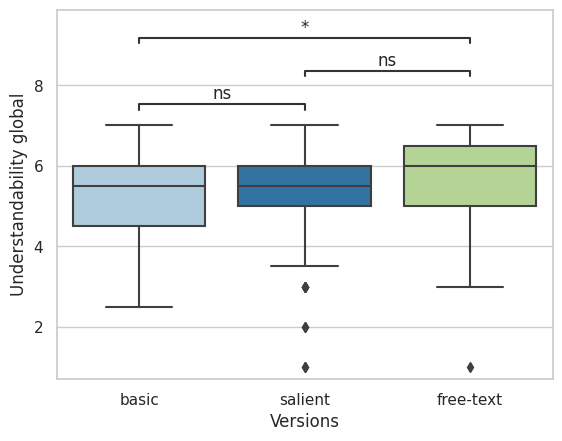

In [540]:
col_palette = states_palette = sns.color_palette("Paired")

states_order = ["basic", "salient", "free-text"]

data4 = df[["METADATA.FEATURE", "understandability_overall_global"]]

pairs = [
    ("basic", "salient"),
    ("basic", "free-text"),
    ("free-text", "salient")
]

plot_params = {
    'data': data4,
    'x': 'METADATA.FEATURE',
    'y': 'understandability_overall_global',
    'order': states_order,
    'palette': col_palette
}

with sns.plotting_context('notebook'):
    # Create new plot
    ax = sns.boxplot()

    # Plot with seaborn
    sns.boxplot(**plot_params).set(xlabel='Versions', ylabel='Understandability global')

    # Add annotations
    annotator = Annotator(ax, pairs, **plot_params)
    annotator.configure(test='Mann-Whitney').apply_and_annotate()

    plt.savefig("/content/sig_understandability_global.png", dpi=300, bbox_inches="tight")

    # Label and show
    plt.show()


## compare local understandability between V1 vs V2 vs V3

In [541]:
kruskal, pairwise, stats = perform_kruskal_with_posthoc(df, "understandability_overall_local", print_results=False);


In [542]:
kruskal

,Source,ddof1,H,p-unc
Kruskal,METADATA.FEATURE,2,21.955524,0.000017


In [543]:
stats

,count,mean,std,min,25%,50%,75%,max
METADATA.FEATURE,,,,,,,,
basic,133.0,5.923559,0.865664,2.666667,5.500000,6.000000,6.500000,7.0
free-text,133.0,6.353383,0.796414,1.000000,6.000000,6.666667,7.000000,7.0
salient,140.0,6.210714,0.739329,3.833333,5.833333,6.333333,6.833333,7.0


low p value indicates significant differences

In [544]:
kruskal, posthoc, stats = perform_kruskal_with_posthoc(df, "understandability_overall_local", print_results=False);
posthoc


,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,METADATA.FEATURE,basic,free-text,False,False,5951.5,two-sided,0.000003,0.000010,holm,-0.515296
1,METADATA.FEATURE,basic,salient,False,False,7469.5,two-sided,0.004525,0.009050,holm,-0.356457
2,METADATA.FEATURE,free-text,salient,False,False,10521.5,two-sided,0.060692,0.060692,holm,0.185334


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

basic vs. salient: Mann-Whitney-Wilcoxon test two-sided, P_val:4.525e-03 U_stat=7.470e+03
salient vs. free-text: Mann-Whitney-Wilcoxon test two-sided, P_val:6.069e-02 U_stat=8.098e+03
basic vs. free-text: Mann-Whitney-Wilcoxon test two-sided, P_val:3.421e-06 U_stat=5.952e+03


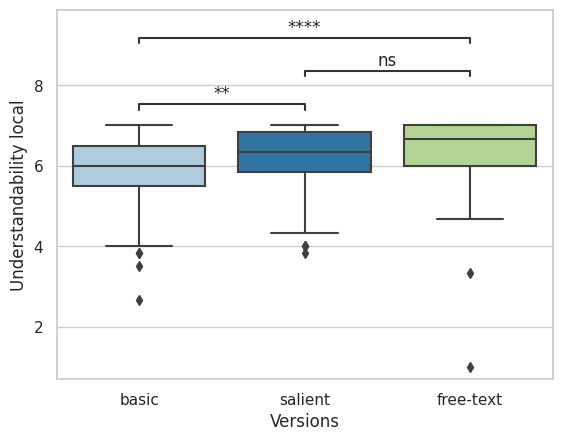

In [545]:
col_palette = states_palette = sns.color_palette("Paired", n_colors=5)

states_order = ["basic", "salient", "free-text"]

data4 = df[["METADATA.FEATURE", "understandability_overall_local"]]

pairs = [
    ("basic", "salient"),
    ("basic", "free-text"),
    ("free-text", "salient")
]

plot_params = {
    'data': data4,
    'x': 'METADATA.FEATURE',
    'y': 'understandability_overall_local',
    'order': states_order,
    'palette': col_palette
}

with sns.plotting_context('notebook'):
    # Create new plot
    ax = sns.boxplot()

    # Plot with seaborn
    sns.boxplot(**plot_params).set(xlabel='Versions', ylabel='Understandability local')

    # Add annotations
    annotator = Annotator(ax, pairs, **plot_params)
    annotator.configure(test='Mann-Whitney').apply_and_annotate()

    plt.savefig("/content/sig_understandability_local.png", dpi=300, bbox_inches="tight")

    # Label and show
    plt.show()


In [546]:
a = df[df['METADATA.FEATURE'] == 'basic']["understandability_overall_local"]
b = df[df['METADATA.FEATURE'] == 'salient']["understandability_overall_local"]
c = df[df['METADATA.FEATURE'] == 'free-text']["understandability_overall_local"]

d = cohend(a, b)
print('basic vs salient')
print(d)

print('basic vs free-text')
e = cohend(a, c)
print(e)

print('freetext vs salient-text')
f = cohend(b,c)
print(f)


basic vs salient
-0.3574473581257893
basic vs free-text
-0.5167652905686269
freetext vs salient-text
-0.18584833806078366


## compare global VS local in each version


In [547]:
feature_categories = df["METADATA.FEATURE"].unique()
wilcoxon_results = []
descriptive_stats = []

for category in feature_categories:
    category_df = df[df["METADATA.FEATURE"] == category]  # Filtern des DataFrame für die aktuelle Kategorie

    wilcoxon_test = pg.wilcoxon(category_df["understandability_overall_global"], category_df["understandability_overall_local"])

    stats = category_df[["understandability_overall_global", "understandability_overall_local"]].describe()

    wilcoxon_results.append(wilcoxon_test)
    descriptive_stats.append(stats)

    print("Category:", category)
    print(wilcoxon_test)
    stats

Category: basic
           W-val alternative         p-val       RBC      CLES
Wilcoxon  1132.0   two-sided  5.966176e-09 -0.635779  0.346373
Category: salient
          W-val alternative         p-val       RBC      CLES
Wilcoxon  493.5   two-sided  7.830036e-17 -0.868453  0.277755
Category: free-text
          W-val alternative         p-val       RBC      CLES
Wilcoxon  663.0   two-sided  1.168010e-14 -0.814286  0.286591


In [548]:
a = df[df['METADATA.FEATURE'] == 'basic']["understandability_overall_local"]
b = df[df['METADATA.FEATURE'] == 'basic']["understandability_overall_global"]

c = df[df['METADATA.FEATURE'] == 'salient']["understandability_overall_local"]
d= df[df['METADATA.FEATURE'] == 'salient']["understandability_overall_global"]

e = df[df['METADATA.FEATURE'] == 'free-text']["understandability_overall_local"]
f= df[df['METADATA.FEATURE'] == 'free-text']["understandability_overall_global"]

g = cohend(a, b)
print('basic')
print(g)

print('salient')
h = cohend(c, d)
print(h)

print('freetext')
i = cohend(e,f)
print(i)


basic
0.5937070794378885
salient
0.8398089892934241
freetext
0.7669679574761151


## compare laymen vs journalist

wie statistischer vergleich, wenn zu wenig daten da sind?
exemplarischer vergleich

In [549]:
calculate_stats(df_journos[df_journos['METADATA.FEATURE'] == 'basic'][['understandability_overall_global']])
#calculate_stats(df_journos[df_journos['METADATA.FEATURE'] == 'salient'][['understandability_overall_global']])
#calculate_stats(df_journos[df_journos['METADATA.FEATURE'] == 'free-text'][['understandability_overall_global']])

#calculate_stats(df_journos[df_journos['METADATA.FEATURE'] == 'basic'][['understandability_overall_local']])


no normal distribution since p value below 0.05


,Column,Shapiro-Wilk,p-value,Mean,Median
0,understandability_overall_global,0.74258,0.010607,4.285714,5.0


In [550]:
results_df = compare_laymen_journos(df_journos, df, 'understandability_overall_global', True)
print(results_df)

     Feature  Statistic   p-value
0      basic      280.0  0.073578
1  free-text      606.0  0.637753
2    salient      718.0  0.893660


In [551]:
results_df = compare_laymen_journos(df_journos, df, 'understandability_overall_local', True)
print(results_df)

     Feature  Statistic   p-value
0      basic      216.0  0.016599
1  free-text      439.5  0.071766
2    salient      508.0  0.146035


In [552]:
a = df[df['METADATA.FEATURE'] == 'basic']["understandability_overall_global"]
b = df_journos[df_journos['METADATA.FEATURE'] == 'basic']["understandability_overall_global"]

c = df[df['METADATA.FEATURE'] == 'salient']["understandability_overall_global"]
d = df_journos[df_journos['METADATA.FEATURE'] == 'salient']["understandability_overall_global"]

e = df[df['METADATA.FEATURE'] == 'free-text']["understandability_overall_global"]
f = df_journos[df_journos['METADATA.FEATURE'] == 'free-text']["understandability_overall_global"]

g = cohend(a, b)
print('basic')
print(g)

print('salient')
h = cohend(c, d)
print(h)

print('freetext')
i = cohend(e,f)
print(i)

basic
0.8763397463183792
salient
-0.029643810352616005
freetext
0.061480505600992996


In [553]:
a = df[df['METADATA.FEATURE'] == 'basic']["understandability_overall_local"]
b = df_journos[df_journos['METADATA.FEATURE'] == 'basic']["understandability_overall_local"]

c = df[df['METADATA.FEATURE'] == 'salient']["understandability_overall_local"]
d = df_journos[df_journos['METADATA.FEATURE'] == 'salient']["understandability_overall_local"]

e = df[df['METADATA.FEATURE'] == 'free-text']["understandability_overall_local"]
f = df_journos[df_journos['METADATA.FEATURE'] == 'free-text']["understandability_overall_local"]

g = cohend(a, b)
print('basic')
print(g)

print('salient')
h = cohend(c, d)
print(h)

print('freetext')
i = cohend(e,f)
print(i)


basic
1.4336648863194397
salient
0.3771727259150533
freetext
0.5648342829058335


#RQ 1: Trust

## compare global trust between V1 vs V2 vs V3

In [554]:
kruskal, pairwise, stats = perform_kruskal_with_posthoc(df, "trust_overall_global", print_results=False);


In [555]:
kruskal

,Source,ddof1,H,p-unc
Kruskal,METADATA.FEATURE,2,11.987159,0.002495


In [556]:
stats

,count,mean,std,min,25%,50%,75%,max
METADATA.FEATURE,,,,,,,,
basic,133.0,4.828947,1.124787,2.1875,4.0000,4.875,5.6250,7.0
free-text,133.0,5.250000,1.093087,1.5625,4.6875,5.250,6.1250,7.0
salient,140.0,5.130804,1.135540,1.5000,4.4375,5.375,5.9375,7.0


low p value indicates significant differences

In [557]:
kruskal, posthoc, stats = perform_kruskal_with_posthoc(df, "trust_overall_global", print_results=False);
posthoc

,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,METADATA.FEATURE,basic,free-text,False,False,6775.5,two-sided,0.000974,0.002922,holm,-0.378572
1,METADATA.FEATURE,basic,salient,False,False,7611.0,two-sided,0.009174,0.018348,holm,-0.266315
2,METADATA.FEATURE,free-text,salient,False,False,9729.0,two-sided,0.520877,0.520877,holm,0.106600


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

basic vs. salient: Mann-Whitney-Wilcoxon test two-sided, P_val:9.174e-03 U_stat=7.611e+03
salient vs. free-text: Mann-Whitney-Wilcoxon test two-sided, P_val:5.209e-01 U_stat=8.891e+03
basic vs. free-text: Mann-Whitney-Wilcoxon test two-sided, P_val:9.739e-04 U_stat=6.776e+03


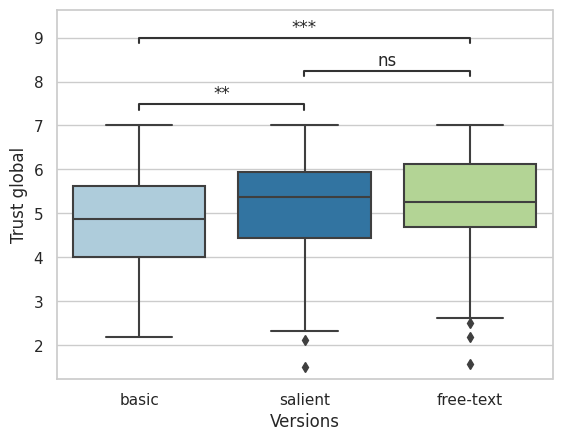

In [558]:
col_palette = states_palette = sns.color_palette("Paired", n_colors=5)

states_order = ["basic", "salient", "free-text"]

data4 = df[["METADATA.FEATURE", "trust_overall_global"]]

pairs = [
    ("basic", "salient"),
    ("basic", "free-text"),
    ("free-text", "salient")
]

plot_params = {
    'data': data4,
    'x': 'METADATA.FEATURE',
    'y': 'trust_overall_global',
    'order': states_order,
    'palette': col_palette
}

with sns.plotting_context('notebook'):
    # Create new plot
    ax = sns.boxplot()

    # Plot with seaborn
    sns.boxplot(**plot_params).set(xlabel='Versions', ylabel='Trust global')

    # Add annotations
    annotator = Annotator(ax, pairs, **plot_params)
    annotator.configure(test='Mann-Whitney').apply_and_annotate()

    plt.savefig("/content/sig_trust_global.png", dpi=300, bbox_inches="tight")

    # Label and show
    plt.show()


In [559]:
a = df[df['METADATA.FEATURE'] == 'basic']["trust_overall_global"]
b = df[df['METADATA.FEATURE'] == 'salient']["trust_overall_global"]
c = df[df['METADATA.FEATURE'] == 'free-text']["trust_overall_global"]

d = cohend(a, b)
print('basic vs salient')
print(d)

print('basic vs free-text')
e = cohend(a, c)
print(e)

print('freetext vs salient-text')
f = cohend(b,c)
print(f)


basic vs salient
-0.2670549804448898
basic vs free-text
-0.3796515839648338
freetext vs salient-text
-0.10689654427512055


## compare local trust between V1 vs V2 vs V3

In [560]:
kruskal, pairwise, stats = perform_kruskal_with_posthoc(df, "trust_overall_local", print_results=False);


In [561]:
kruskal

,Source,ddof1,H,p-unc
Kruskal,METADATA.FEATURE,2,18.30915,0.000106


In [562]:
stats

,count,mean,std,min,25%,50%,75%,max
METADATA.FEATURE,,,,,,,,
basic,133.0,6.070175,0.607009,3.750000,5.666667,6.166667,6.583333,7.0
free-text,133.0,6.350251,0.617741,3.666667,6.000000,6.500000,6.833333,7.0
salient,140.0,6.242857,0.621482,3.166667,5.916667,6.333333,6.666667,7.0


In [563]:
kruskal, posthoc, stats = perform_kruskal_with_posthoc(df, "trust_overall_local", print_results=False);
posthoc

,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,METADATA.FEATURE,basic,free-text,False,False,6220.5,two-sided,0.000028,0.000085,holm,-0.456041
1,METADATA.FEATURE,basic,salient,False,False,7576.5,two-sided,0.007774,0.015548,holm,-0.280245
2,METADATA.FEATURE,free-text,salient,False,False,10440.5,two-sided,0.082446,0.082446,holm,0.172830


In [564]:
a = df[df['METADATA.FEATURE'] == 'basic']["trust_overall_local"]
b = df[df['METADATA.FEATURE'] == 'salient']["trust_overall_local"]
c = df[df['METADATA.FEATURE'] == 'free-text']["trust_overall_local"]

d = cohend(a, b)
print('basic vs salient')
print(d)

print('basic vs free-text')
e = cohend(a, c)
print(e)

print('freetext vs salient-text')
f = cohend(b,c)
print(f)


basic vs salient
-0.28102323086231956
basic vs free-text
-0.4573415705431833
freetext vs salient-text
-0.173309686102473


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

basic vs. salient: Mann-Whitney-Wilcoxon test two-sided, P_val:7.774e-03 U_stat=7.576e+03
salient vs. free-text: Mann-Whitney-Wilcoxon test two-sided, P_val:8.245e-02 U_stat=8.180e+03
basic vs. free-text: Mann-Whitney-Wilcoxon test two-sided, P_val:2.818e-05 U_stat=6.220e+03


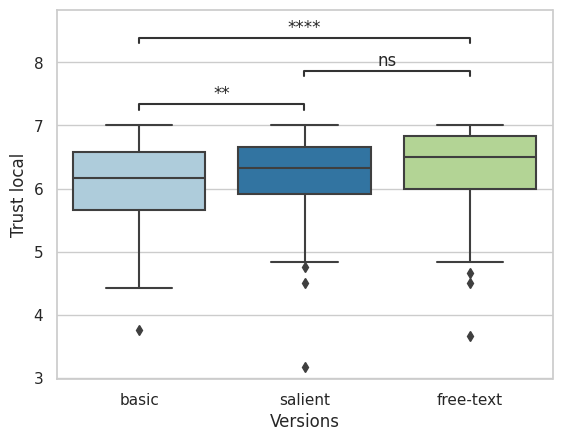

In [565]:
col_palette = states_palette = sns.color_palette("Paired", n_colors=5)

states_order = ["basic", "salient", "free-text"]

data4 = df[["METADATA.FEATURE", "trust_overall_local"]]

pairs = [
    ("basic", "salient"),
    ("basic", "free-text"),
    ("free-text", "salient")
]

plot_params = {
    'data': data4,
    'x': 'METADATA.FEATURE',
    'y': 'trust_overall_local',
    'order': states_order,
    'palette': col_palette
}

with sns.plotting_context('notebook'):
    # Create new plot
    ax = sns.boxplot()

    # Plot with seaborn
    sns.boxplot(**plot_params).set(xlabel='Versions', ylabel='Trust local')

    # Add annotations
    annotator = Annotator(ax, pairs, **plot_params)
    annotator.configure(test='Mann-Whitney').apply_and_annotate()

    plt.savefig("/content/sig_trust_local.png", dpi=300, bbox_inches="tight")

    # Label and show
    plt.show()


## compare global VS local in each version

In [566]:
feature_categories = df["METADATA.FEATURE"].unique()
wilcoxon_results = []
descriptive_stats = []

for category in feature_categories:
    category_df = df[df["METADATA.FEATURE"] == category]  # Filtern des DataFrame für die aktuelle Kategorie

    wilcoxon_test = pg.wilcoxon(category_df["trust_overall_global"], category_df["trust_overall_local"])

    stats = category_df[["trust_overall_global", "trust_overall_local"]].describe()

    wilcoxon_results.append(wilcoxon_test)
    descriptive_stats.append(stats)

    print("Category:", category)
    print(wilcoxon_results)
    stats


Category: basic
[          W-val alternative         p-val       RBC      CLES
Wilcoxon  193.5   two-sided  3.636270e-21 -0.954551  0.169399]
Category: salient
[          W-val alternative         p-val       RBC      CLES
Wilcoxon  193.5   two-sided  3.636270e-21 -0.954551  0.169399,           W-val alternative         p-val       RBC      CLES
Wilcoxon  186.0   two-sided  2.651224e-22 -0.960069  0.181097]
Category: free-text
[          W-val alternative         p-val       RBC      CLES
Wilcoxon  193.5   two-sided  3.636270e-21 -0.954551  0.169399,           W-val alternative         p-val       RBC      CLES
Wilcoxon  186.0   two-sided  2.651224e-22 -0.960069  0.181097,           W-val alternative         p-val       RBC      CLES
Wilcoxon   83.0   two-sided  6.668217e-22 -0.979893  0.186048]


In [567]:
a = df[df['METADATA.FEATURE'] == 'basic']["trust_overall_local"]
b = df[df['METADATA.FEATURE'] == 'basic']["trust_overall_global"]

c = df[df['METADATA.FEATURE'] == 'salient']["trust_overall_local"]
d= df[df['METADATA.FEATURE'] == 'salient']["trust_overall_global"]

e = df[df['METADATA.FEATURE'] == 'free-text']["trust_overall_local"]
f= df[df['METADATA.FEATURE'] == 'free-text']["trust_overall_global"]

g = cohend(a, b)
print('basic')
print(g)

print('salient')
h = cohend(c, d)
print(h)

print('freetext')
i = cohend(e,f)
print(i)


basic
1.3733873590088546
salient
1.2149094432234637
freetext
1.2392746235630816


## compare laymen vs journalist

In [568]:
#calculate_stats(df_journos[df_journos['METADATA.FEATURE'] == 'basic'][['trust_overall_global']])
#calculate_stats(df_journos[df_journos['METADATA.FEATURE'] == 'salient'][['trust_overall_global']])
#calculate_stats(df_journos[df_journos['METADATA.FEATURE'] == 'free-text'][['trust_overall_global']])
#calculate_stats(df_journos[df_journos['METADATA.FEATURE'] == 'basic'][['trust_overall_local']])
calculate_stats(df_journos[df_journos['METADATA.FEATURE'] == 'salient'][['trust_overall_local']])


normal distribution since p value higher than 0.05


,Column,Shapiro-Wilk,p-value,Mean,Median
0,trust_overall_local,0.863445,0.083778,5.908333,6.0


In [569]:
results_df = compare_laymen_journos(df_journos, df, 'trust_overall_global', True)
print(results_df)

     Feature  Statistic   p-value
0      basic      356.5  0.299392
1  free-text      850.0  0.144002
2    salient      787.0  0.514458


In [570]:
results_df = compare_laymen_journos(df_journos, df, 'trust_overall_local',True)
print(results_df)

     Feature  Statistic   p-value
0      basic      245.0  0.035217
1  free-text      505.5  0.207137
2    salient      427.0  0.039676


In [571]:
a = df[df['METADATA.FEATURE'] == 'basic']["trust_overall_global"]
b = df_journos[df_journos['METADATA.FEATURE'] == 'basic']["trust_overall_global"]

c = df[df['METADATA.FEATURE'] == 'salient']["trust_overall_global"]
d = df_journos[df_journos['METADATA.FEATURE'] == 'salient']["trust_overall_global"]

e = df[df['METADATA.FEATURE'] == 'free-text']["trust_overall_global"]
f = df_journos[df_journos['METADATA.FEATURE'] == 'free-text']["trust_overall_global"]

g = cohend(a, b)
print('basic')
print(g)

print('salient')
h = cohend(c, d)
print(h)

print('freetext')
i = cohend(e,f)
print(i)

basic
0.5436280193456954
salient
-0.22338741812830534
freetext
-0.45329194276500007


In [572]:
a = df[df['METADATA.FEATURE'] == 'basic']["trust_overall_local"]
b = df_journos[df_journos['METADATA.FEATURE'] == 'basic']["trust_overall_local"]

c = df[df['METADATA.FEATURE'] == 'salient']["trust_overall_local"]
d = df_journos[df_journos['METADATA.FEATURE'] == 'salient']["trust_overall_local"]

e = df[df['METADATA.FEATURE'] == 'free-text']["trust_overall_local"]
f = df_journos[df_journos['METADATA.FEATURE'] == 'free-text']["trust_overall_local"]

g = cohend(a, b)
print('basic')
print(g)

print('salient')
h = cohend(c, d)
print(h)

print('freetext')
i = cohend(e,f)
print(i)

basic
1.2553142230864736
salient
0.5449853673671581
freetext
0.2721975654183596


#RQ 1: Usefulness

## compare global usefulness between V1 vs V2 vs V3

In [573]:
kruskal, pairwise, stats = perform_kruskal_with_posthoc(df, "usefulness_overall_global", print_results=False);


In [574]:
kruskal

,Source,ddof1,H,p-unc
Kruskal,METADATA.FEATURE,2,15.60395,0.000409


In [575]:
stats

,count,mean,std,min,25%,50%,75%,max
METADATA.FEATURE,,,,,,,,
basic,133.0,5.219298,0.943784,2.333333,4.666667,5.333333,6.000000,7.0
free-text,133.0,5.665414,0.875330,2.000000,5.000000,5.833333,6.166667,7.0
salient,140.0,5.466667,1.060180,2.333333,5.000000,5.666667,6.166667,7.0


In [576]:
kruskal, posthoc, stats = perform_kruskal_with_posthoc(df, "usefulness_overall_global", print_results=False);
posthoc

,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,METADATA.FEATURE,basic,free-text,False,False,6355.0,two-sided,0.000070,0.000209,holm,-0.488735
1,METADATA.FEATURE,basic,salient,False,False,7748.0,two-sided,0.016440,0.032881,holm,-0.245414
2,METADATA.FEATURE,free-text,salient,False,False,10235.5,two-sided,0.155055,0.155055,holm,0.203376


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

basic vs. salient: Mann-Whitney-Wilcoxon test two-sided, P_val:1.644e-02 U_stat=7.748e+03
salient vs. free-text: Mann-Whitney-Wilcoxon test two-sided, P_val:1.551e-01 U_stat=8.384e+03
basic vs. free-text: Mann-Whitney-Wilcoxon test two-sided, P_val:6.983e-05 U_stat=6.355e+03


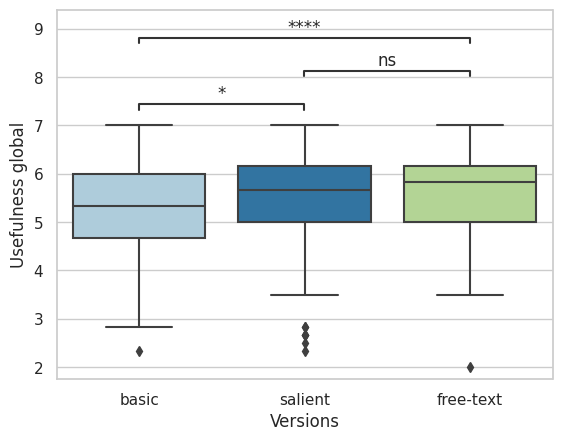

In [578]:
col_palette = states_palette = sns.color_palette("Paired", n_colors=5)

states_order = ["basic", "salient", "free-text"]

data4 = df[["METADATA.FEATURE", "usefulness_overall_global"]]

pairs = [
    ("basic", "salient"),
    ("basic", "free-text"),
    ("free-text", "salient")
]

plot_params = {
    'data': data4,
    'x': 'METADATA.FEATURE',
    'y': 'usefulness_overall_global',
    'order': states_order,
    'palette': col_palette
}

with sns.plotting_context('notebook'):
    # Create new plot
    ax = sns.boxplot()

    # Plot with seaborn
    sns.boxplot(**plot_params).set(xlabel='Versions', ylabel='Usefulness global')

    # Add annotations
    annotator = Annotator(ax, pairs, **plot_params)
    annotator.configure(test='Mann-Whitney').apply_and_annotate()

    plt.savefig("/content/sig_usefulness_global.png", dpi=300, bbox_inches="tight")

    # Label and show
    plt.show()


In [579]:
a = df[df['METADATA.FEATURE'] == 'basic']["usefulness_overall_global"]
b = df[df['METADATA.FEATURE'] == 'salient']["usefulness_overall_global"]
c = df[df['METADATA.FEATURE'] == 'free-text']["usefulness_overall_global"]

d = cohend(a, b)
print('basic vs salient')
print(d)

print('basic vs free-text')
e = cohend(a, c)
print(e)

print('freetext vs salient-text')
f = cohend(b,c)
print(f)


basic vs salient
-0.24609611624072042
basic vs free-text
-0.49012863925092603
freetext vs salient-text
-0.2039408744356069


## compare local usefulness between V1 vs V2 vs V3

In [580]:
kruskal, pairwise, stats = perform_kruskal_with_posthoc(df, "usefulness_overall_local", print_results=False);


In [581]:
kruskal

,Source,ddof1,H,p-unc
Kruskal,METADATA.FEATURE,2,21.690465,0.000019


In [582]:
stats

,count,mean,std,min,25%,50%,75%,max
METADATA.FEATURE,,,,,,,,
basic,133.0,5.906015,0.763033,3.333333,5.500000,6.000000,6.416667,7.0
free-text,133.0,6.281328,0.742074,2.000000,6.000000,6.416667,6.833333,7.0
salient,140.0,6.128571,0.767181,3.666667,5.833333,6.166667,6.833333,7.0


In [583]:
kruskal, posthoc, stats = perform_kruskal_with_posthoc(df, "usefulness_overall_local", print_results=False);
posthoc

,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,METADATA.FEATURE,basic,free-text,False,False,5921.0,two-sided,0.000003,0.000009,holm,-0.497253
1,METADATA.FEATURE,basic,salient,False,False,7525.0,two-sided,0.006109,0.012218,holm,-0.290056
2,METADATA.FEATURE,free-text,salient,False,False,10514.5,two-sided,0.063726,0.063726,holm,0.201752


In [584]:
a = df[df['METADATA.FEATURE'] == 'basic']["usefulness_overall_local"]
b = df[df['METADATA.FEATURE'] == 'salient']["usefulness_overall_local"]
c = df[df['METADATA.FEATURE'] == 'free-text']["usefulness_overall_local"]

d = cohend(a, b)
print('basic vs salient')
print(d)

print('basic vs free-text')
e = cohend(a, c)
print(e)

print('freetext vs salient-text')
f = cohend(b,c)
print(f)


basic vs salient
-0.29086130879936073
basic vs free-text
-0.49867142999165215
freetext vs salient-text
-0.20231204788048807


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

basic vs. salient: Mann-Whitney-Wilcoxon test two-sided, P_val:6.109e-03 U_stat=7.525e+03
salient vs. free-text: Mann-Whitney-Wilcoxon test two-sided, P_val:6.373e-02 U_stat=8.106e+03
basic vs. free-text: Mann-Whitney-Wilcoxon test two-sided, P_val:3.025e-06 U_stat=5.921e+03


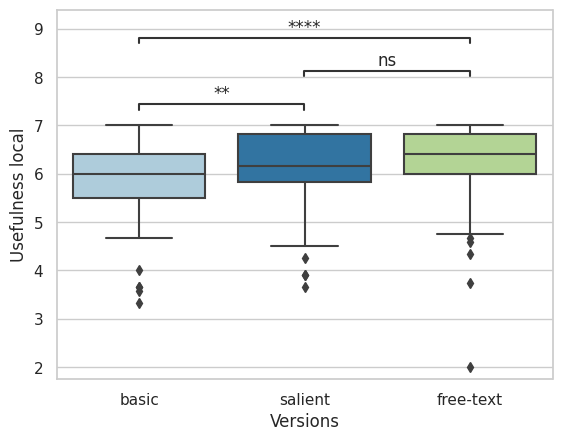

In [586]:
col_palette = states_palette = sns.color_palette("Paired", n_colors=5)

states_order = ["basic", "salient", "free-text"]

data4 = df[["METADATA.FEATURE", "usefulness_overall_local"]]

pairs = [
    ("basic", "salient"),
    ("basic", "free-text"),
    ("free-text", "salient")
]

plot_params = {
    'data': data4,
    'x': 'METADATA.FEATURE',
    'y': 'usefulness_overall_local',
    'order': states_order,
    'palette': col_palette
}

with sns.plotting_context('notebook'):
    # Create new plot
    ax = sns.boxplot()

    # Plot with seaborn
    sns.boxplot(**plot_params).set(xlabel='Versions', ylabel='Usefulness local')

    # Add annotations
    annotator = Annotator(ax, pairs, **plot_params)
    annotator.configure(test='Mann-Whitney').apply_and_annotate()

    plt.savefig("/content/sig_usefulness_local.png", dpi=300, bbox_inches="tight")

    # Label and show
    plt.show()


## compare global VS local in each version

In [587]:
feature_categories = df["METADATA.FEATURE"].unique()
wilcoxon_results = []
descriptive_stats = []

for category in feature_categories:
    category_df = df[df["METADATA.FEATURE"] == category]

    wilcoxon_test = pg.wilcoxon(category_df["usefulness_overall_global"], category_df["usefulness_overall_local"])

    stats = category_df[["usefulness_overall_global", "usefulness_overall_local"]].describe()

    wilcoxon_results.append(wilcoxon_test)
    descriptive_stats.append(stats)

    print("Category:", category)
    print(wilcoxon_results)
    stats

Category: basic
[          W-val alternative         p-val       RBC      CLES
Wilcoxon  827.0   two-sided  1.098962e-14 -0.793276  0.281446]
Category: salient
[          W-val alternative         p-val       RBC      CLES
Wilcoxon  827.0   two-sided  1.098962e-14 -0.793276  0.281446,           W-val alternative         p-val       RBC      CLES
Wilcoxon  813.5   two-sided  5.161733e-15 -0.799828  0.303878]
Category: free-text
[          W-val alternative         p-val       RBC      CLES
Wilcoxon  827.0   two-sided  1.098962e-14 -0.793276  0.281446,           W-val alternative         p-val       RBC      CLES
Wilcoxon  813.5   two-sided  5.161733e-15 -0.799828  0.303878,           W-val alternative         p-val       RBC      CLES
Wilcoxon  724.5   two-sided  6.371633e-15 -0.809992  0.271468]


In [588]:
a = df[df['METADATA.FEATURE'] == 'basic']["usefulness_overall_local"]
b = df[df['METADATA.FEATURE'] == 'basic']["usefulness_overall_global"]

c = df[df['METADATA.FEATURE'] == 'salient']["usefulness_overall_local"]
d= df[df['METADATA.FEATURE'] == 'salient']["usefulness_overall_global"]

e = df[df['METADATA.FEATURE'] == 'free-text']["usefulness_overall_local"]
f= df[df['METADATA.FEATURE'] == 'free-text']["usefulness_overall_global"]

g = cohend(a, b)
print('basic')
print(g)

print('salient')
h = cohend(c, d)
print(h)

print('freetext')
i = cohend(e,f)
print(i)


basic
0.8002010583707451
salient
0.715301672257362
freetext
0.7590375129013807


## compare laymen vs journalist

In [589]:
#calculate_stats(df_journos[df_journos['METADATA.FEATURE'] == 'basic'][['usefulness_overall_global']])
#calculate_stats(df_journos[df_journos['METADATA.FEATURE'] == 'salient'][['usefulness_overall_global']])
#calculate_stats(df_journos[df_journos['METADATA.FEATURE'] == 'free-text'][['usefulness_overall_global']])
calculate_stats(df_journos[df_journos['METADATA.FEATURE'] == 'basic'][['usefulness_overall_local']])


no normal distribution since p value below 0.05


,Column,Shapiro-Wilk,p-value,Mean,Median
0,usefulness_overall_local,0.769836,0.020352,4.357143,4.916667


In [590]:
results_df = compare_laymen_journos(df_journos, df, 'usefulness_overall_global', True)
print(results_df)

     Feature  Statistic   p-value
0      basic      319.5  0.163350
1  free-text      633.0  0.802433
2    salient      767.0  0.615633


In [591]:
results_df = compare_laymen_journos(df_journos, df, 'usefulness_overall_local',True)
print(results_df)

     Feature  Statistic   p-value
0      basic      111.5  0.000716
1  free-text      460.5  0.104719
2    salient      531.5  0.204045


In [592]:
a = df[df['METADATA.FEATURE'] == 'basic']["usefulness_overall_global"]
b = df_journos[df_journos['METADATA.FEATURE'] == 'basic']["usefulness_overall_global"]

c = df[df['METADATA.FEATURE'] == 'salient']["usefulness_overall_global"]
d = df_journos[df_journos['METADATA.FEATURE'] == 'salient']["usefulness_overall_global"]

e = df[df['METADATA.FEATURE'] == 'free-text']["usefulness_overall_global"]
f = df_journos[df_journos['METADATA.FEATURE'] == 'free-text']["usefulness_overall_global"]

g = cohend(a, b)
print('basic')
print(g)

print('salient')
h = cohend(c, d)
print(h)

print('freetext')
i = cohend(e,f)
print(i)

basic
0.6309606502541975
salient
-0.22390803504479748
freetext
0.01785699750444601


In [593]:
a = df[df['METADATA.FEATURE'] == 'basic']["usefulness_overall_local"]
b = df_journos[df_journos['METADATA.FEATURE'] == 'basic']["usefulness_overall_local"]

c = df[df['METADATA.FEATURE'] == 'salient']["usefulness_overall_local"]
d = df_journos[df_journos['METADATA.FEATURE'] == 'salient']["usefulness_overall_local"]

e = df[df['METADATA.FEATURE'] == 'free-text']["usefulness_overall_local"]
f = df_journos[df_journos['METADATA.FEATURE'] == 'free-text']["usefulness_overall_local"]

g = cohend(a, b)
print('basic')
print(g)

print('salient')
h = cohend(c, d)
print(h)

print('freetext')
i = cohend(e,f)
print(i)

basic
1.8995375565691413
salient
0.3004282934954871
freetext
0.6177717574866938


# RQ 1: Expectation in AI

In [594]:
# new entrie for change in expectation
df['change_in_ai_exp'] = df['expectations_after_ai_overall'] - df['expectation_before_ai_overall']


In [595]:
kruskal, pairwise, stats = perform_kruskal_with_posthoc(df, "change_in_ai_exp", print_results=False);
kruskal

,Source,ddof1,H,p-unc
Kruskal,METADATA.FEATURE,2,14.784939,0.000616


In [596]:
print(df['expectation_before_ai_overall'].mean())

4.590147783251231


In [597]:
stats

,count,mean,std,min,25%,50%,75%,max
METADATA.FEATURE,,,,,,,,
basic,133.0,-0.160526,0.788940,-3.35,-0.60,-0.10,0.30,2.05
free-text,133.0,0.144737,0.763472,-2.60,-0.30,0.15,0.55,2.15
salient,140.0,-0.137500,0.741405,-2.60,-0.55,-0.20,0.25,2.00


In [598]:
#compare before and after
feature_categories = df["METADATA.FEATURE"].unique()
wilcoxon_results = []
descriptive_stats = []

for category in feature_categories:
    category_df = df[df["METADATA.FEATURE"] == category]  # Filtern des DataFrame für die aktuelle Kategorie

    wilcoxon_test = pg.wilcoxon(category_df["expectation_before_ai_overall"], category_df["expectations_after_ai_overall"])

    stats = category_df[["expectation_before_ai_overall", "expectations_after_ai_overall"]].describe()

    wilcoxon_results.append(wilcoxon_test)
    descriptive_stats.append(stats)

    print("Category:", category)
    print(wilcoxon_results)
    stats


Category: basic
[           W-val alternative     p-val       RBC      CLES
Wilcoxon  2972.0   two-sided  0.024386  0.233032  0.546837]
Category: salient
[           W-val alternative     p-val       RBC      CLES
Wilcoxon  2972.0   two-sided  0.024386  0.233032  0.546837,            W-val alternative     p-val       RBC      CLES
Wilcoxon  3515.0   two-sided  0.013054  0.245384  0.529439]
Category: free-text
[           W-val alternative     p-val       RBC      CLES
Wilcoxon  2972.0   two-sided  0.024386  0.233032  0.546837,            W-val alternative     p-val       RBC      CLES
Wilcoxon  3515.0   two-sided  0.013054  0.245384  0.529439,            W-val alternative     p-val       RBC      CLES
Wilcoxon  3425.5   two-sided  0.028669 -0.219526  0.443524]


In [599]:
a = df[df['METADATA.FEATURE'] == 'basic']["expectation_before_ai_overall"]
b = df[df['METADATA.FEATURE'] == 'basic']["expectations_after_ai_overall"]

c = df[df['METADATA.FEATURE'] == 'salient']["expectation_before_ai_overall"]
d= df[df['METADATA.FEATURE'] == 'salient']["expectations_after_ai_overall"]

e = df[df['METADATA.FEATURE'] == 'free-text']["expectation_before_ai_overall"]
f= df[df['METADATA.FEATURE'] == 'free-text']["expectations_after_ai_overall"]

g = cohend(a, b)
print('basic')
print(g)

print('salient')
h = cohend(c, d)
print(h)

print('freetext')
i = cohend(e,f)
print(i)


basic
0.16116764704897837
salient
0.1223300980883269
freetext
-0.12603824148775555


In [600]:
#check if change in ai is sig different in versions
kruskal, pairwise, stats = perform_kruskal_with_posthoc(df, "change_in_ai_exp", print_results=False);
kruskal

,Source,ddof1,H,p-unc
Kruskal,METADATA.FEATURE,2,14.784939,0.000616


In [601]:
kruskal, posthoc, stats = perform_kruskal_with_posthoc(df, "change_in_ai_exp", print_results=False);
posthoc

,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,METADATA.FEATURE,basic,free-text,False,False,6857.5,two-sided,0.001538,0.003077,holm,-0.392105
1,METADATA.FEATURE,basic,salient,False,False,9491.0,two-sided,0.781852,0.781852,holm,-0.030019
2,METADATA.FEATURE,free-text,salient,False,False,11578.0,two-sided,0.000504,0.001513,holm,0.374159


In [602]:
a = df[df['METADATA.FEATURE'] == 'basic']["change_in_ai_exp"]
b = df[df['METADATA.FEATURE'] == 'salient']["change_in_ai_exp"]
c = df[df['METADATA.FEATURE'] == 'free-text']["change_in_ai_exp"]

d = cohend(a, b)
print('basic vs salient')
print(d)

print('basic vs free-text')
e = cohend(a, c)
print(e)

print('freetext vs salient-text')
f = cohend(b,c)
print(f)


basic vs salient
-0.030102614682884065
basic vs free-text
-0.39322318017653096
freetext vs salient-text
-0.37519823911522177


In [603]:
feature_categories = df["METADATA.FEATURE"].unique()
wilcoxon_results = []
descriptive_stats = []

# Schleife über die Kategorien
for category in feature_categories:
    category_df = df[df["METADATA.FEATURE"] == category]  # Filtern des DataFrame für die aktuelle Kategorie

    # Deskriptive Statistik berechnen
    stats = category_df["change_in_ai_exp"].describe()
    before = category_df['expectation_before_ai_overall'].mean()
    after = category_df['expectations_after_ai_overall'].mean()

    # Ausgabe der Ergebnisse für die aktuelle Kategorie
    print("Category:", category)
    print(before)
    print(after)
    stats

Category: basic
4.62857142857143
4.4680451127819545
Category: salient
4.635714285714286
4.498214285714286
Category: free-text
4.503759398496241
4.648496240601504


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

basic vs. salient: Mann-Whitney-Wilcoxon test two-sided, P_val:7.819e-01 U_stat=9.491e+03
salient vs. free-text: Mann-Whitney-Wilcoxon test two-sided, P_val:5.043e-04 U_stat=7.042e+03
basic vs. free-text: Mann-Whitney-Wilcoxon test two-sided, P_val:1.538e-03 U_stat=6.858e+03


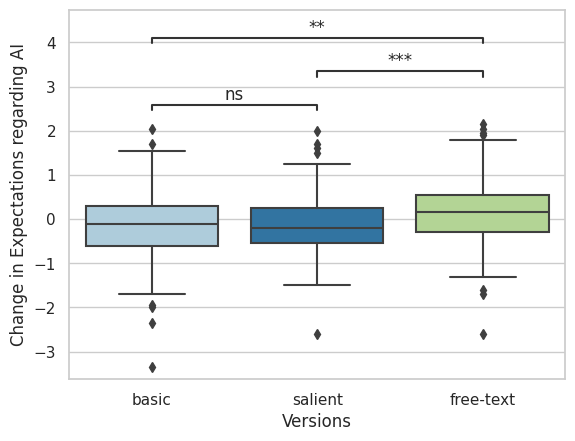

In [604]:
col_palette = states_palette = sns.color_palette("Paired", n_colors=5)

states_order = ["basic", "salient", "free-text"]

data4 = df[["METADATA.FEATURE", "change_in_ai_exp"]]

pairs = [
    ("basic", "salient"),
    ("basic", "free-text"),
    ("free-text", "salient")
]

plot_params = {
    'data': data4,
    'x': 'METADATA.FEATURE',
    'y': 'change_in_ai_exp',
    'order': states_order,
    'palette': col_palette
}

with sns.plotting_context('notebook'):
    # Create new plot
    ax = sns.boxplot()

    # Plot with seaborn
    sns.boxplot(**plot_params).set(xlabel='Versions', ylabel='Change in Expectations regarding AI')

    # Add annotations
    annotator = Annotator(ax, pairs, **plot_params)
    annotator.configure(test='Mann-Whitney').apply_and_annotate()

    plt.savefig("/content/sig_exp_change.png", dpi=300, bbox_inches="tight")

    # Label and show
    plt.show()


#RQ1: Correlation between categories\ for each group

##basic

In [605]:
columns = ['understandability_overall_global', 'trust_overall_global', 'usefulness_overall_global', 'understandability_overall_local', 'trust_overall_local', 'usefulness_overall_local']
corr_matrix, posthoc_results, modi_df = perform_spearman_corr(df, columns, 'basic')
corr_matrix_basic = corr_matrix
# Display 4x4 correlation matrix

In [606]:
posthoc_results[['X', 'Y', 'r', 'p-corr']]


,X,Y,r,p-corr
0,understandability_overall_global,trust_overall_global,0.615710,7.741087e-15
1,understandability_overall_global,usefulness_overall_global,0.713478,2.804338e-21
2,understandability_overall_global,understandability_overall_local,0.452892,4.727681e-08
3,understandability_overall_global,trust_overall_local,0.351023,3.433968e-05
4,understandability_overall_global,usefulness_overall_local,0.508892,6.652862e-10
5,trust_overall_global,usefulness_overall_global,0.681159,6.934615e-19
6,trust_overall_global,understandability_overall_local,0.458444,3.558162e-08
7,trust_overall_global,trust_overall_local,0.457529,3.558162e-08
8,trust_overall_global,usefulness_overall_local,0.570042,1.708469e-12
9,usefulness_overall_global,understandability_overall_local,0.491104,2.928422e-09


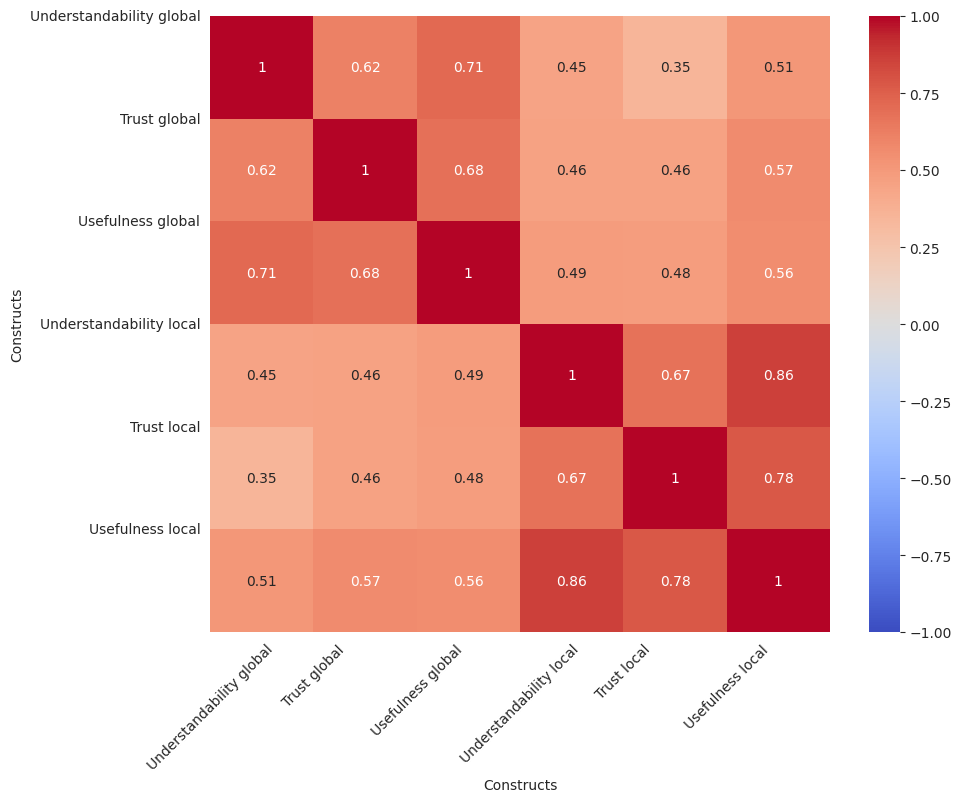

In [607]:
# Update construct labels
label_mapping = {
    'understandability_overall_global': 'Understandability global',
    'understandability_overall_local': 'Understandability local',
    'trust_overall_global': 'Trust global',
    'trust_overall_local': 'Trust local',
    'usefulness_overall_global': 'Usefulness global',
    'usefulness_overall_local': 'Usefulness local'
}

columns_updated = [label_mapping.get(column, column) for column in columns]

# Compute the correlation matrix
corr_matrix = corr_matrix_basic

# Create a heatmap
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

# Set the updated labels and axis labels
plt.xticks(ticks=range(len(columns)), labels=columns_updated, ha='center', rotation=45)
plt.yticks(ticks=range(len(columns)), labels=columns_updated, va='center')

plt.xlabel('Constructs')
plt.ylabel('Constructs')

# Display the plot
plt.savefig('correaltion_of_constructs_basic.png', bbox_inches='tight')

# Display the plot
plt.show()


In [608]:
nonparametric_regression(df, 'basic', 'understandability_overall_local', 'usefulness_overall_local', 'regression_und_trust_local.png')


                               OLS Regression Results                               
Dep. Variable:     usefulness_overall_local   R-squared:                       0.808
Model:                                  OLS   Adj. R-squared:                  0.806
Method:                       Least Squares   F-statistic:                     550.6
Date:                      Tue, 25 Jul 2023   Prob (F-statistic):           9.44e-49
Time:                              11:54:24   Log-Likelihood:                -42.576
No. Observations:                       133   AIC:                             89.15
Df Residuals:                           131   BIC:                             94.93
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

<ipython-input-460-2534fe2b7f79>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['constant'] = 1


In [609]:
nonparametric_regression(df, 'basic', 'understandability_overall_global', 'change_in_ai_exp', 'regression_under_change_global.png')

                            OLS Regression Results                            
Dep. Variable:       change_in_ai_exp   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     10.38
Date:                Tue, 25 Jul 2023   Prob (F-statistic):            0.00161
Time:                        11:54:24   Log-Likelihood:                -151.62
No. Observations:                 133   AIC:                             307.2
Df Residuals:                     131   BIC:                             313.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
understa

<ipython-input-460-2534fe2b7f79>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['constant'] = 1


In [610]:
nonparametric_regression(df, 'basic', 'trust_overall_global', 'usefulness_overall_global', 'regr_trust_usefulness')

                                OLS Regression Results                               
Dep. Variable:     usefulness_overall_global   R-squared:                       0.491
Model:                                   OLS   Adj. R-squared:                  0.487
Method:                        Least Squares   F-statistic:                     126.4
Date:                       Tue, 25 Jul 2023   Prob (F-statistic):           6.08e-21
Time:                               11:54:24   Log-Likelihood:                -135.61
No. Observations:                        133   AIC:                             275.2
Df Residuals:                            131   BIC:                             281.0
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

<ipython-input-460-2534fe2b7f79>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['constant'] = 1


##salient

In [611]:
columns = ['understandability_overall_global', 'trust_overall_global', 'usefulness_overall_global', 'understandability_overall_local', 'trust_overall_local', 'usefulness_overall_local']
corr_matrix, posthoc_results, modi_df = perform_spearman_corr(df, columns, 'salient')

corr_matrix_salient = corr_matrix
# Display 4x4 correlation matrix

In [612]:
corr_matrix_salient

,understandability_overall_global,trust_overall_global,usefulness_overall_global,understandability_overall_local,trust_overall_local,usefulness_overall_local
understandability_overall_global,1.000000,0.624748,0.650999,0.590317,0.510828,0.482586
trust_overall_global,0.624748,1.000000,0.679031,0.549172,0.598324,0.562571
usefulness_overall_global,0.650999,0.679031,1.000000,0.553752,0.576439,0.590717
understandability_overall_local,0.590317,0.549172,0.553752,1.000000,0.762991,0.863037
trust_overall_local,0.510828,0.598324,0.576439,0.762991,1.000000,0.807503
usefulness_overall_local,0.482586,0.562571,0.590717,0.863037,0.807503,1.000000


In [613]:
posthoc_results[['X', 'Y', 'r', 'p-corr']]


,X,Y,r,p-corr
0,understandability_overall_global,trust_overall_global,0.624748,3.992408e-16
1,understandability_overall_global,usefulness_overall_global,0.650999,9.336770e-18
2,understandability_overall_global,understandability_overall_local,0.590317,2.739280e-14
3,understandability_overall_global,trust_overall_local,0.510828,1.211177e-10
4,understandability_overall_global,usefulness_overall_local,0.482586,1.560107e-09
5,trust_overall_global,usefulness_overall_global,0.679031,1.108596e-19
6,trust_overall_global,understandability_overall_local,0.549172,2.456911e-12
7,trust_overall_global,trust_overall_local,0.598324,1.259384e-14
8,trust_overall_global,usefulness_overall_local,0.562571,6.409609e-13
9,usefulness_overall_global,understandability_overall_local,0.553752,1.600093e-12


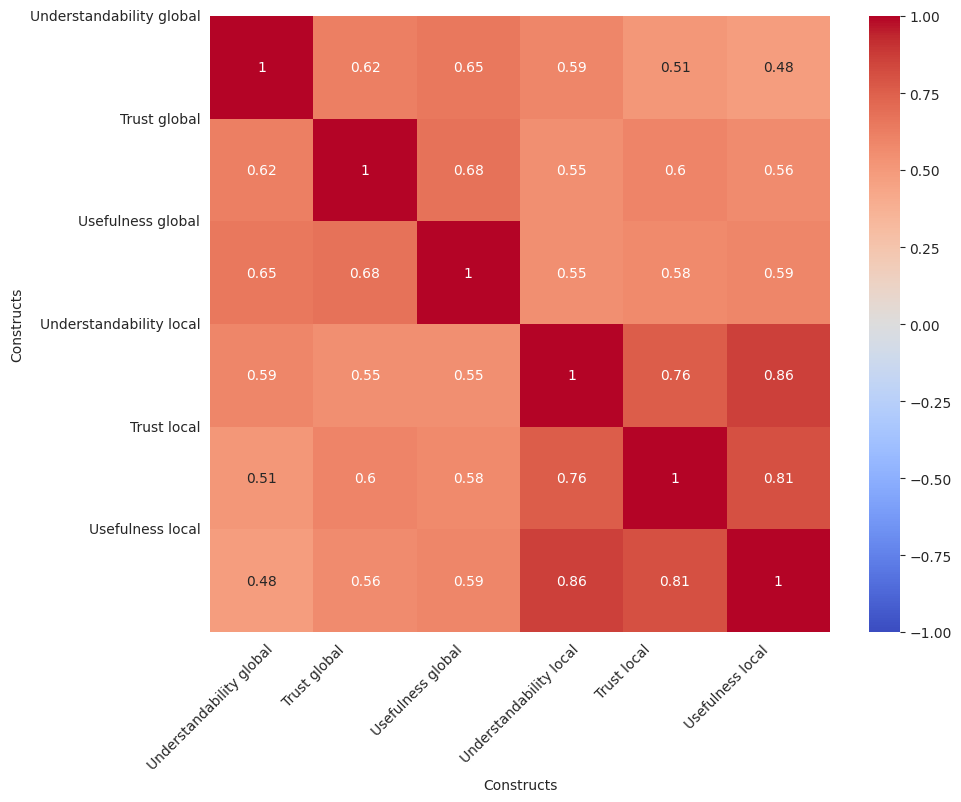

In [614]:
# Update construct labels
label_mapping = {
    'understandability_overall_global': 'Understandability global',
    'understandability_overall_local': 'Understandability local',
    'trust_overall_global': 'Trust global',
    'trust_overall_local': 'Trust local',
    'usefulness_overall_global': 'Usefulness global',
    'usefulness_overall_local': 'Usefulness local'
}

columns_updated = [label_mapping.get(column, column) for column in columns]

# Compute the correlation matrix
corr_matrix = corr_matrix_salient

# Create a heatmap
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

# Set the updated labels and axis labels
plt.xticks(ticks=range(len(columns)), labels=columns_updated, ha='center', rotation=45)
plt.yticks(ticks=range(len(columns)), labels=columns_updated, va='center')

plt.xlabel('Constructs')
plt.ylabel('Constructs')

# Display the plot
plt.savefig('correaltion_of_constructs_salient.png', bbox_inches='tight')

# Display the plot
plt.show()


In [615]:
results = nonparametric_regression(df, 'salient', 'understandability_overall_local', 'usefulness_overall_local', 'regression_und_trust_local_salient.png')


                               OLS Regression Results                               
Dep. Variable:     usefulness_overall_local   R-squared:                       0.744
Model:                                  OLS   Adj. R-squared:                  0.742
Method:                       Least Squares   F-statistic:                     400.2
Date:                      Tue, 25 Jul 2023   Prob (F-statistic):           1.30e-42
Time:                              11:54:27   Log-Likelihood:                -65.781
No. Observations:                       140   AIC:                             135.6
Df Residuals:                           138   BIC:                             141.4
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

<ipython-input-460-2534fe2b7f79>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['constant'] = 1


##explanation

In [616]:
columns = ['understandability_overall_global', 'trust_overall_global', 'usefulness_overall_global', 'understandability_overall_local', 'trust_overall_local', 'usefulness_overall_local']
corr_matrix, posthoc_results, modi_df = perform_spearman_corr(df, columns, 'free-text')
corr_matrix_freetext = corr_matrix
# Display 4x4 correlation matrix

In [617]:
corr_matrix

,understandability_overall_global,trust_overall_global,usefulness_overall_global,understandability_overall_local,trust_overall_local,usefulness_overall_local
understandability_overall_global,1.000000,0.561002,0.653797,0.479000,0.533363,0.498612
trust_overall_global,0.561002,1.000000,0.608795,0.526804,0.629172,0.536369
usefulness_overall_global,0.653797,0.608795,1.000000,0.506963,0.521534,0.525704
understandability_overall_local,0.479000,0.526804,0.506963,1.000000,0.742652,0.889417
trust_overall_local,0.533363,0.629172,0.521534,0.742652,1.000000,0.832393
usefulness_overall_local,0.498612,0.536369,0.525704,0.889417,0.832393,1.000000


In [618]:
posthoc_results[['X', 'Y', 'r', 'p-corr']]


,X,Y,r,p-corr
0,understandability_overall_global,trust_overall_global,0.561002,4.643937e-12
1,understandability_overall_global,usefulness_overall_global,0.653797,5.413978e-17
2,understandability_overall_global,understandability_overall_local,0.479000,5.464624e-09
3,understandability_overall_global,trust_overall_local,0.533363,6.416679e-11
4,understandability_overall_global,usefulness_overall_local,0.498612,1.082242e-09
5,trust_overall_global,usefulness_overall_global,0.608795,1.900506e-14
6,trust_overall_global,understandability_overall_local,0.526804,1.100957e-10
7,trust_overall_global,trust_overall_local,0.629172,1.515664e-15
8,trust_overall_global,usefulness_overall_local,0.536369,5.345774e-11
9,usefulness_overall_global,understandability_overall_local,0.506963,5.495204e-10


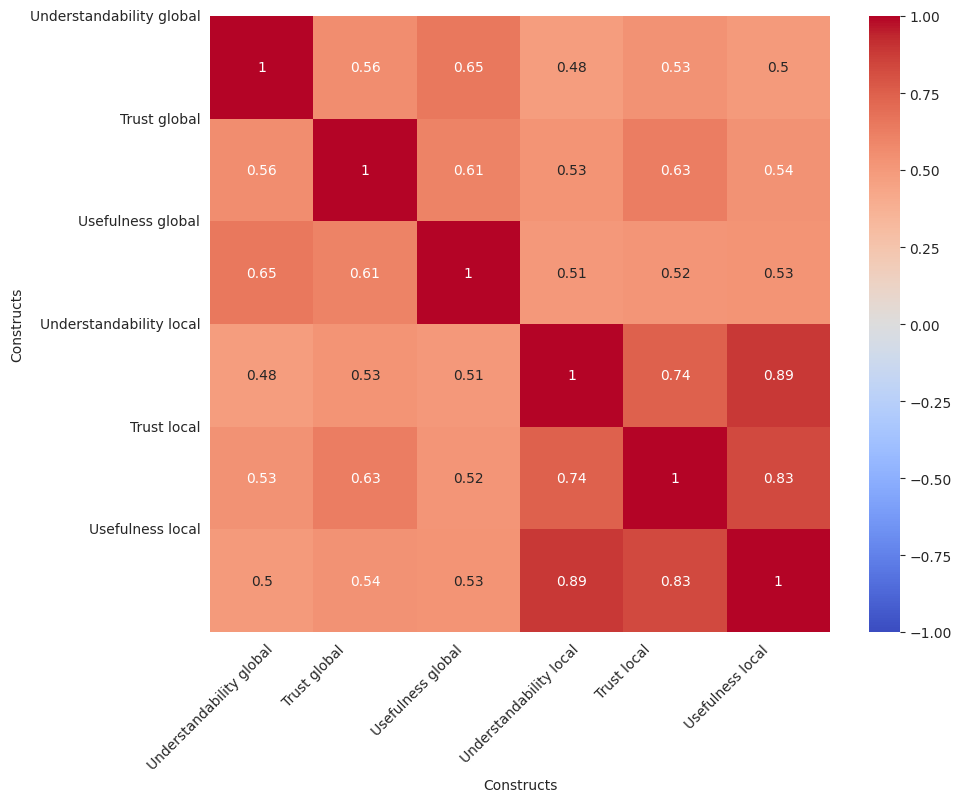

In [619]:
# Update construct labels
label_mapping = {
    'understandability_overall_global': 'Understandability global',
    'understandability_overall_local': 'Understandability local',
    'trust_overall_global': 'Trust global',
    'trust_overall_local': 'Trust local',
    'usefulness_overall_global': 'Usefulness global',
    'usefulness_overall_local': 'Usefulness local'
}

columns_updated = [label_mapping.get(column, column) for column in columns]

# Compute the correlation matrix
corr_matrix = corr_matrix_freetext

# Create a heatmap
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

# Set the updated labels and axis labels
plt.xticks(ticks=range(len(columns)), labels=columns_updated, ha='center', rotation=45)
plt.yticks(ticks=range(len(columns)), labels=columns_updated, va='center')

plt.xlabel('Constructs')
plt.ylabel('Constructs')

# Display the plot
plt.savefig('correaltion_of_constructs_freetext.png', bbox_inches='tight')

# Display the plot
plt.show()


In [620]:
results = nonparametric_regression(df, 'free-text', 'understandability_overall_local', 'usefulness_overall_local', 'regression_und_trust_local_expl.png')


                               OLS Regression Results                               
Dep. Variable:     usefulness_overall_local   R-squared:                       0.862
Model:                                  OLS   Adj. R-squared:                  0.861
Method:                       Least Squares   F-statistic:                     816.2
Date:                      Tue, 25 Jul 2023   Prob (F-statistic):           3.97e-58
Time:                              11:54:29   Log-Likelihood:                -16.984
No. Observations:                       133   AIC:                             37.97
Df Residuals:                           131   BIC:                             43.75
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

<ipython-input-460-2534fe2b7f79>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['constant'] = 1


## all versions

In [621]:
columns = ['understandability_overall_global', 'trust_overall_global', 'usefulness_overall_global', 'understandability_overall_local', 'trust_overall_local', 'usefulness_overall_local']
corr_matrix, posthoc_results, modi_df = perform_spearman_corr(df, columns, 'all')
corr_matrix_av = corr_matrix
# Display 4x4 correlation matrix

In [622]:
posthoc_results[['X', 'Y', 'r', 'p-corr']]


,X,Y,r,p-corr
0,understandability_overall_global,trust_overall_global,0.611945,1.119854e-42
1,understandability_overall_global,usefulness_overall_global,0.683212,1.485804e-56
2,understandability_overall_global,understandability_overall_local,0.525691,3.645608e-30
3,understandability_overall_global,trust_overall_local,0.474486,3.484506e-24
4,understandability_overall_global,usefulness_overall_local,0.503212,2.033218e-27
5,trust_overall_global,usefulness_overall_global,0.671590,4.319451e-54
6,trust_overall_global,understandability_overall_local,0.535754,1.922430e-31
7,trust_overall_global,trust_overall_local,0.583220,4.285953e-38
8,trust_overall_global,usefulness_overall_local,0.579617,1.376741e-37
9,usefulness_overall_global,understandability_overall_local,0.553647,7.511758e-34


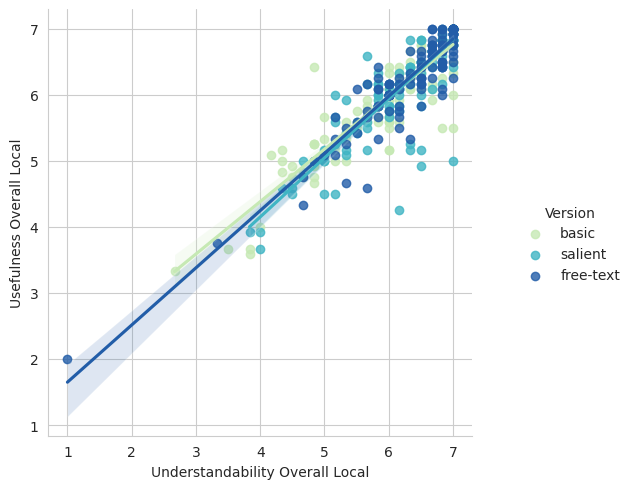

                               OLS Regression Results                               
Dep. Variable:     usefulness_overall_local   R-squared:                       0.807
Model:                                  OLS   Adj. R-squared:                  0.807
Method:                       Least Squares   F-statistic:                     1694.
Date:                      Tue, 25 Jul 2023   Prob (F-statistic):          1.33e-146
Time:                              11:54:33   Log-Likelihood:                -135.65
No. Observations:                       406   AIC:                             275.3
Df Residuals:                           404   BIC:                             283.3
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

In [623]:
sns.set_style('whitegrid')
plot = sns.lmplot(x='understandability_overall_local', y='usefulness_overall_local', data=df, hue='METADATA.FEATURE', palette='YlGnBu')

plot.set_axis_labels("Understandability Overall Local", "Usefulness Overall Local")
plot._legend.set_title("Version")

plt.savefig('/content/regression_understandability_usefulness_local.png')  # Save the plot as PNG
plt.show()

results = nonparametric_regression(df, 'all', 'understandability_overall_local', 'usefulness_overall_local')


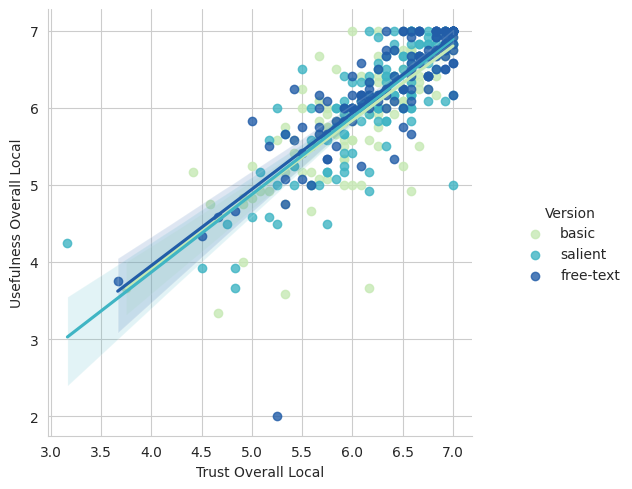

                               OLS Regression Results                               
Dep. Variable:     usefulness_overall_local   R-squared:                       0.656
Model:                                  OLS   Adj. R-squared:                  0.655
Method:                       Least Squares   F-statistic:                     769.6
Date:                      Tue, 25 Jul 2023   Prob (F-statistic):           1.37e-95
Time:                              11:54:35   Log-Likelihood:                -253.59
No. Observations:                       406   AIC:                             511.2
Df Residuals:                           404   BIC:                             519.2
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------

In [624]:

sns.set_style('whitegrid')
plot = sns.lmplot(x='trust_overall_local', y='usefulness_overall_local', data=df, hue='METADATA.FEATURE', palette='YlGnBu')

plot.set_axis_labels("Trust Overall Local", "Usefulness Overall Local")
plot._legend.set_title("Version")

plt.savefig('/content/regression_trust_usefulness_local.png')  # Save the plot as PNG
plt.show()

results = nonparametric_regression(df, 'all', 'trust_overall_local', 'usefulness_overall_local')




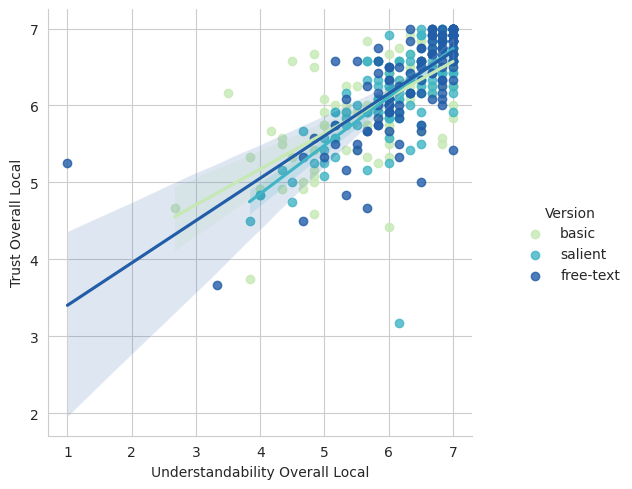

                             OLS Regression Results                            
Dep. Variable:     trust_overall_local   R-squared:                       0.512
Model:                             OLS   Adj. R-squared:                  0.510
Method:                  Least Squares   F-statistic:                     423.2
Date:                 Tue, 25 Jul 2023   Prob (F-statistic):           7.52e-65
Time:                         11:54:37   Log-Likelihood:                -239.05
No. Observations:                  406   AIC:                             482.1
Df Residuals:                      404   BIC:                             490.1
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------


In [625]:

sns.set_style('whitegrid')
plot = sns.lmplot(x='understandability_overall_local', y='trust_overall_local', data=df, hue='METADATA.FEATURE', palette='YlGnBu')

plot.set_axis_labels("Understandability Overall Local", "Trust Overall Local")
plot._legend.set_title("Version")

plt.savefig('/content/regression_understandability_trust_local.png')  # Save the plot as PNG
plt.show()

results = nonparametric_regression(df, 'all', 'understandability_overall_local', 'trust_overall_local')

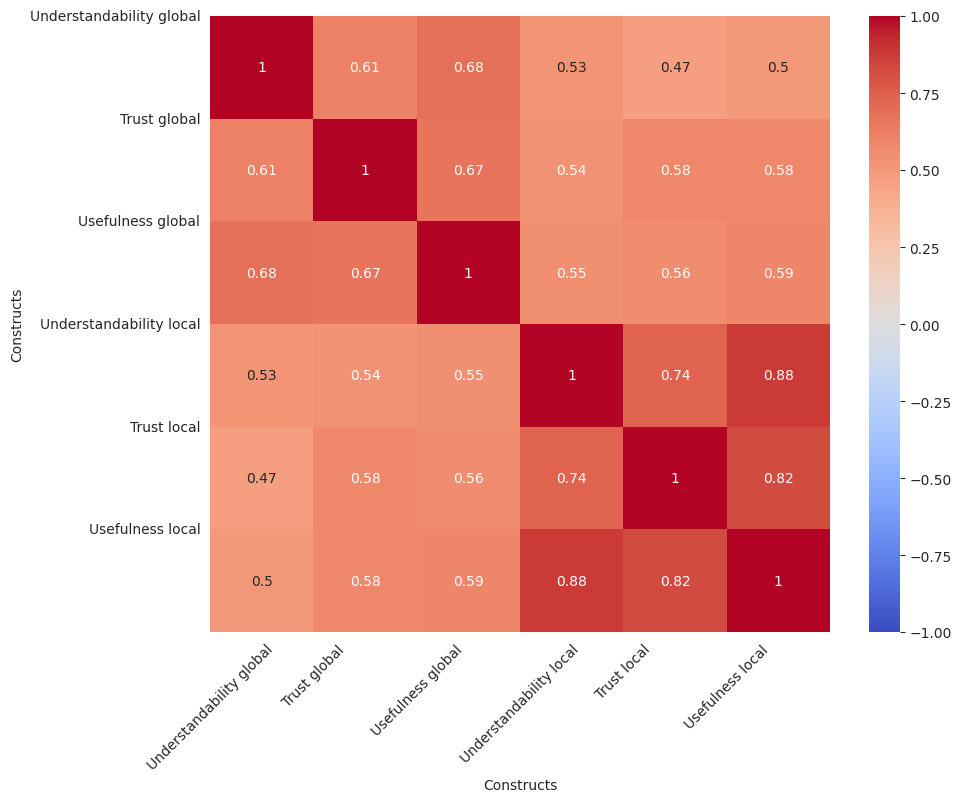

In [626]:
# Update construct labels
label_mapping = {
    'understandability_overall_global': 'Understandability global',
    'understandability_overall_local': 'Understandability local',
    'trust_overall_global': 'Trust global',
    'trust_overall_local': 'Trust local',
    'usefulness_overall_global': 'Usefulness global',
    'usefulness_overall_local': 'Usefulness local'
}

columns_updated = [label_mapping.get(column, column) for column in columns]

# Compute the correlation matrix
corr_matrix = corr_matrix_av

# Create a heatmap
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

# Set the updated labels and axis labels
plt.xticks(ticks=range(len(columns)), labels=columns_updated, ha='center', rotation=45)
plt.yticks(ticks=range(len(columns)), labels=columns_updated, va='center')

plt.xlabel('Constructs')
plt.ylabel('Constructs')

# Display the plot
plt.savefig('correaltion_of_constructs.png', bbox_inches='tight')

# Display the plot
plt.show()


#RQ 2:
{SRQ 1: Do Participants with higher information literacy classify news items closer to the correct machine score, regardless of their group?}

## Correlations

In [627]:
columns = ['understandability_overall_global', 'trust_overall_global', 'usefulness_overall_global', 'understandability_overall_local', 'trust_overall_local', 'usefulness_overall_local', 'change_in_ai_exp', 'information_literacy_overall','age_numerical','gender_numerical', 'edu_numerical', 'income_numerical', 'expectation_before_ai_overall', 'human_accuracy', 'accuracy_change', 'most_used_source_numerical', 'correct_human_detection']
corr_matrix, posthoc_results, modi_df = perform_spearman_corr(df, columns, 'all')
# Display 4x4 correlation matrixc
corr_matrix
posthoc_results[['X', 'Y', 'r', 'p-corr']]



,X,Y,r,p-corr
0,understandability_overall_global,trust_overall_global,0.611945,8.702865e-42
1,understandability_overall_global,usefulness_overall_global,0.683212,1.077703e-55
2,understandability_overall_global,understandability_overall_local,0.525691,2.685598e-29
3,understandability_overall_global,trust_overall_local,0.474486,2.632738e-23
4,understandability_overall_global,usefulness_overall_local,0.503212,1.518136e-26
...,...,...,...,...
131,human_accuracy,most_used_source_numerical,0.070888,2.918655e-01
132,human_accuracy,correct_human_detection,0.936704,4.219910e-184
133,accuracy_change,most_used_source_numerical,0.010604,8.902296e-01
134,accuracy_change,correct_human_detection,-0.578169,1.561968e-36


In [628]:
posthoc_results[['X', 'Y', 'r', 'p-corr']].to_csv("/content/correlation_analysis.csv", index=False)


###Information Literacy

In [629]:
import scipy.stats as stats
calculate_spearman_correlation(df, 'information_literacy_overall', 'human_accuracy')


Correlation:  0.008281208337004301
p_value:  0.8678814326449563


(0.008281208337004301, 0.8678814326449563)

In [630]:
corr_il=posthoc_results[(posthoc_results['X'] == 'information_literacy_overall') | (posthoc_results['Y'] == 'information_literacy_overall')]
corr_il[['X', 'Y', 'r', 'p-corr']]

,X,Y,r,p-corr
6,understandability_overall_global,information_literacy_overall,0.180267,1.014880e-03
21,trust_overall_global,information_literacy_overall,0.140350,1.362124e-02
35,usefulness_overall_global,information_literacy_overall,0.237542,5.666211e-06
48,understandability_overall_local,information_literacy_overall,0.271249,1.467876e-07
60,trust_overall_local,information_literacy_overall,0.289921,1.440578e-08
71,usefulness_overall_local,information_literacy_overall,0.315882,4.363716e-10
81,change_in_ai_exp,information_literacy_overall,-0.073023,2.837782e-01
91,information_literacy_overall,age_numerical,-0.062802,3.513413e-01
92,information_literacy_overall,gender_numerical,-0.087298,1.685161e-01
93,information_literacy_overall,edu_numerical,0.035726,6.733135e-01


### Human Accuracy

In [631]:
corr_il=posthoc_results[(posthoc_results['X'] == 'human_accuracy') | (posthoc_results['Y'] == 'human_accuracy')]
corr_il[['X', 'Y', 'r', 'p-corr']]

,X,Y,r,p-corr
12,understandability_overall_global,human_accuracy,-0.092509,1.451281e-01
27,trust_overall_global,human_accuracy,-0.242071,3.736560e-06
41,usefulness_overall_global,human_accuracy,-0.087292,1.685161e-01
54,understandability_overall_local,human_accuracy,-0.014611,8.368214e-01
66,trust_overall_local,human_accuracy,-0.032454,7.031799e-01
77,usefulness_overall_local,human_accuracy,-0.032022,7.031799e-01
87,change_in_ai_exp,human_accuracy,-0.100071,1.065687e-01
96,information_literacy_overall,human_accuracy,0.008281,9.149758e-01
104,age_numerical,human_accuracy,-0.009165,9.073047e-01
111,gender_numerical,human_accuracy,0.029517,7.097010e-01


In [632]:
grouped_data = df.groupby('most_used_source_numerical')['human_accuracy'].mean()
max_avg_accuracy_value = grouped_data.idxmax()
print("The value in 'most_used_source_numerical' where the average value of 'human_accuracy' is highest:", max_avg_accuracy_value)

grouped_data

The value in 'most_used_source_numerical' where the average value of 'human_accuracy' is highest: 6


most_used_source_numerical
1    0.712500
2    0.720588
3    0.695946
4    0.625000
5    0.728125
6    0.744949
7    0.714286
8    0.741379
Name: human_accuracy, dtype: float64

In [633]:
# hat die unabhängige var einen einfluss auf die abhängige
#(df, unabhängig, abhängig)
results = nonparametric_regression(df,'all', 'most_used_source_numerical', 'human_accuracy', 'regre_source_acc')


                            OLS Regression Results                            
Dep. Variable:         human_accuracy   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     2.904
Date:                Tue, 25 Jul 2023   Prob (F-statistic):             0.0891
Time:                        11:54:38   Log-Likelihood:                 174.54
No. Observations:                 406   AIC:                            -345.1
Df Residuals:                     404   BIC:                            -337.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
most_used_source_num

### Correct Human Detection / Amount of correct classified articles

In [634]:
corr_il=posthoc_results[(posthoc_results['X'] == 'correct_human_detection') | (posthoc_results['Y'] == 'correct_human_detection')]
corr_il[['X', 'Y', 'r', 'p-corr']]

,X,Y,r,p-corr
15,understandability_overall_global,correct_human_detection,-0.074183,2.753477e-01
30,trust_overall_global,correct_human_detection,-0.170068,2.071823e-03
44,usefulness_overall_global,correct_human_detection,-0.075024,2.704759e-01
57,understandability_overall_local,correct_human_detection,-0.020368,7.932190e-01
69,trust_overall_local,correct_human_detection,-0.017749,8.042152e-01
80,usefulness_overall_local,correct_human_detection,-0.018794,7.932506e-01
90,change_in_ai_exp,correct_human_detection,-0.091840,1.461923e-01
99,information_literacy_overall,correct_human_detection,0.018948,7.932506e-01
107,age_numerical,correct_human_detection,-0.006158,9.359605e-01
114,gender_numerical,correct_human_detection,0.000899,9.855931e-01


In [635]:
grouped_data = df.groupby('income_numerical')['correct_human_detection'].mean()
max_avg_accuracy_value = grouped_data.idxmax()
print("The value in 'income_numerical' where the average value of 'correct_human_detection' is highest:", max_avg_accuracy_value)

grouped_data

The value in 'income_numerical' where the average value of 'correct_human_detection' is highest: 6


income_numerical
1    3.982759
2    4.181818
3    4.041667
4    3.886364
5    4.060241
6    4.346939
7    4.111111
Name: correct_human_detection, dtype: float64

In [636]:
#kruskal, pairwise, stats = perform_kruskal_with_posthoc_demo(df, 'correct_human_detection', print_results = False)
#kruskal

### Media outlets / sources

In [637]:
column_names = df.columns.tolist()
print(column_names)

['METADATA.FEATURE', 'METADATA.GROUP', 'METADATA.personal-code', 'METADATA.swymerId', 'METADATA.workDurationInSeconds.main', 'METADATA.workDurationInSeconds.qualification', 'POINTS.main', 'POINTS.qualification', 'ai-system-evaluation.additional-functionality', 'ai-system-evaluation.benefit-of-doubt', 'ai-system-evaluation.classification-comprehensible', 'ai-system-evaluation.criteria-to-judge-reliability', 'ai-system-evaluation.easy-to-follow-what-system-does', 'ai-system-evaluation.everyday-work-helpful', 'ai-system-evaluation.know-what-will-happen-next-time', 'ai-system-evaluation.most-useful-explanation-feature', 'ai-system-evaluation.other-information-wish', 'ai-system-evaluation.rely-on-ai-system', 'ai-system-evaluation.sceptical-about-ai-system', 'ai-system-evaluation.system-able-to-classify-news-articles', 'ai-system-evaluation.system-able-to-detect-fake-news', 'ai-system-evaluation.system-can-correctly-classify-news-articles', 'ai-system-evaluation.system-can-efficiently-classi

In [638]:
truthfulness_facebook = df['information-seeking.truthfulness.facebook'].mean()
truthfulness_twitter = df['information-seeking.truthfulness.twitter'].mean()
truthfulness_instagram = df['information-seeking.truthfulness.instagram'].mean()
truthfulness_newspaper = df['information-seeking.truthfulness.newspaper'].mean()
truthfulness_online_newspaper = df['information-seeking.truthfulness.online-newspaper'].mean()

In [639]:
import scipy.stats as stats

statistic_kw, p_value = stats.kruskal(df['information-seeking.truthfulness.facebook'],
                                      df['information-seeking.truthfulness.twitter'],
                                      df['information-seeking.truthfulness.instagram'],
                                      df['information-seeking.truthfulness.newspaper'],
                                      df['information-seeking.truthfulness.online-newspaper'])
print("Kruskal-Wallis-Test")
print("Teststatistik:", statistic_kw)
print("p-Wert:", p_value)

Kruskal-Wallis-Test
Teststatistik: 852.9886978710193
p-Wert: 2.551455936751019e-183


In [640]:
columns = columns = [
    'information-seeking.truthfulness.facebook',
    'information-seeking.truthfulness.instagram',
    'information-seeking.truthfulness.twitter',
    'information-seeking.truthfulness.newspaper',
    'information-seeking.truthfulness.online-newspaper'
]
kruskal, posthoc, stats = perform_kruskal_wallis(df, columns, 'all')
kruskal


KruskalResult(statistic=852.9886978710193, pvalue=2.551455936751019e-183)

In [641]:
# check if participant uses truthfull source or not, ignore intervie and personal talk since its not in the truthfullness ranking
df['use_truthful_source'] = 'not-relevant'
df.loc[df['most_used_source_numerical'].isin([6, 5]), 'use_truthful_source'] = 'Truthful Source'
df.loc[df['most_used_source_numerical'].isin([2, 3, 8]), 'use_truthful_source'] = 'Untruthful Source'

new_df = df.copy()
#df = df[df['use_truthful_source'] != 'not-relevant']

In [642]:
new_df[['most_used_source_numerical','use_truthful_source']]

,most_used_source_numerical,use_truthful_source
0,6,Truthful Source
3,5,Truthful Source
4,6,Truthful Source
6,5,Truthful Source
8,6,Truthful Source
...,...,...
423,5,Truthful Source
424,6,Truthful Source
425,6,Truthful Source
426,3,Untruthful Source


In [643]:
import scipy.stats as stats
df['most_used_source_numerical']
calculate_spearman_correlation(new_df, 'use_truthful_source', 'human_accuracy')


Correlation:  -0.08173708273653878
p_value:  0.10004581262002059


(-0.08173708273653878, 0.10004581262002059)

### human accuracy laypeople vs journalists

In [644]:
df['correct_human_detection'].describe()
df_journos['correct_human_detection'].describe()

count    27.000000
mean      5.037037
std       1.192331
min       2.000000
25%       4.000000
50%       6.000000
75%       6.000000
max       6.000000
Name: correct_human_detection, dtype: float64

In [645]:
df['human_accuracy'].describe()
df_journos['human_accuracy'].describe()


count    27.000000
mean      0.875000
std       0.158872
min       0.500000
25%       0.750000
50%       1.000000
75%       1.000000
max       1.000000
Name: human_accuracy, dtype: float64

In [646]:
df['information_literacy_overall'].describe()
df_journos['information_literacy_overall'].describe()

count    27.000000
mean      5.666667
std       0.632305
min       3.888889
25%       5.444444
50%       5.777778
75%       6.000000
max       6.555556
Name: information_literacy_overall, dtype: float64

In [647]:
results_df = compare_laymen_journos(df_journos, df, 'human_accuracy', False)
print(results_df)

   Statistic   p-value
0     8180.5  0.000011


In [648]:
results_df = compare_laymen_journos(df_journos, df, 'correct_human_detection', False)
print(results_df)

   Statistic   p-value
0     7959.5  0.000045


In [649]:
results_df = compare_laymen_journos(df_journos, df, 'information_literacy_overall', False)
results_df


,Statistic,p-value
0,5030.5,0.474316


In [650]:
a = df[df['METADATA.FEATURE'] == 'basic']["human_accuracy"]
b = df_journos[df_journos['METADATA.FEATURE'] == 'basic']["human_accuracy"]

c = df[df['METADATA.FEATURE'] == 'salient']["correct_human_detection"]
d = df_journos[df_journos['METADATA.FEATURE'] == 'salient']["correct_human_detection"]

e = df[df['METADATA.FEATURE'] == 'free-text']["information_literacy_overall"]
f = df_journos[df_journos['METADATA.FEATURE'] == 'free-text']["information_literacy_overall"]

g = cohend(a, b)
print('human_accuracy')
print(g)

print('correct_human_detection')
h = cohend(c, d)
print(h)

print('freetext')
i = cohend(e,f)
print(i)

human_accuracy
-1.0407657225502245
correct_human_detection
-0.9021359582507738
freetext
0.056396263325317844


In [651]:
#merge df
df['group'] = 'Laypeople'
df_journos['group'] = 'Journalists'
df_allgroups = df.append(df_journos, ignore_index=True)

<ipython-input-651-bab62393af7c>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_allgroups = df.append(df_journos, ignore_index=True)


In [652]:
#df_allgroups

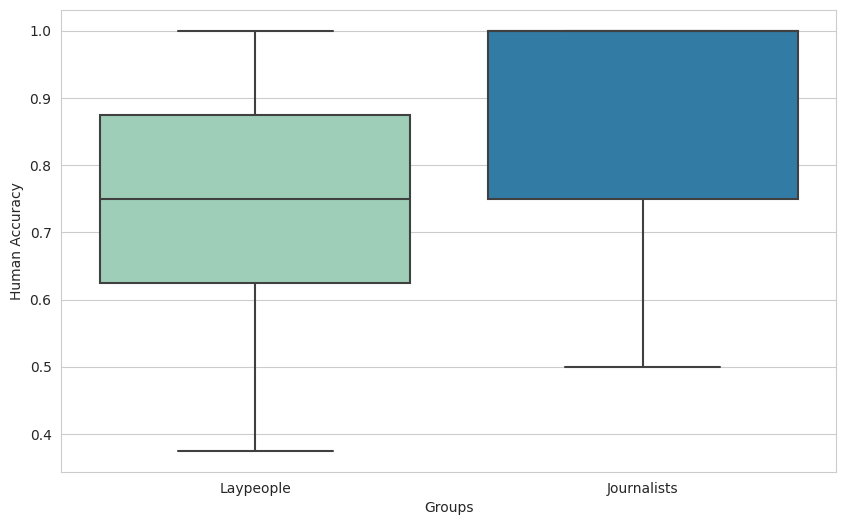

In [653]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the dataframe for 'laypeople' and 'journalist' groups
df_filtered = df_allgroups[df_allgroups['group'].isin(['Laypeople', 'Journalists'])]

# Create the boxplot using seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(x='group', y='human_accuracy', data=df_filtered, palette='YlGnBu')
plt.xlabel('Groups')
plt.ylabel('Human Accuracy')
#plt.title('Comparison of Human Accuracy between Laypeople and Journalists')
plt.savefig('/content/comparison_human_accuracy.png')  # Save the plot as PNG
plt.show()


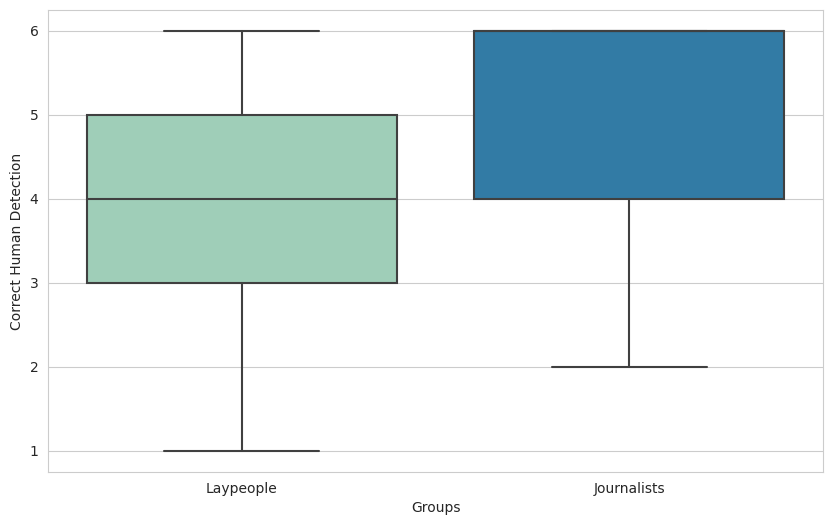

In [654]:
df_filtered = df_allgroups[df_allgroups['group'].isin(['Laypeople', 'Journalists'])]

# Create the boxplot using seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(x='group', y='correct_human_detection', data=df_filtered, palette='YlGnBu')
plt.xlabel('Groups')
plt.ylabel('Correct Human Detection')
#plt.title('Comparison of Human Accuracy between Laypeople and Journalists')
plt.savefig('/content/comparison_correct_detection.png')  # Save the plot as PNG
plt.show()


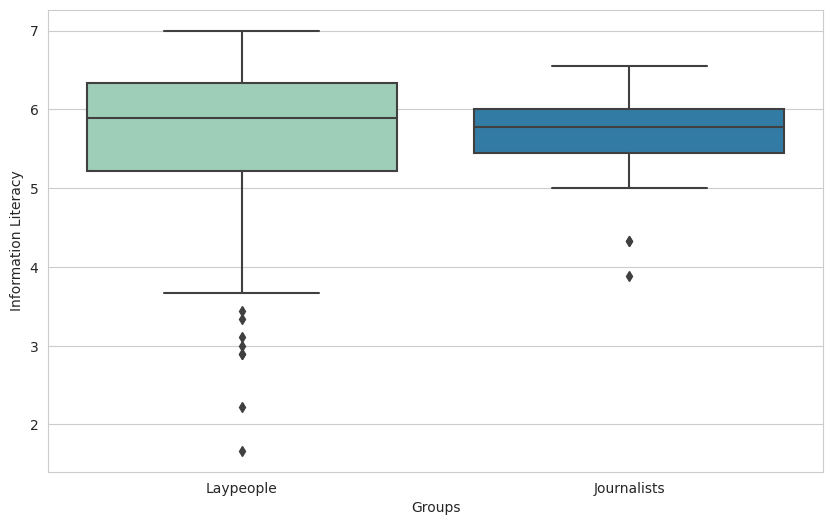

In [655]:
df_filtered = df_allgroups[df_allgroups['group'].isin(['Laypeople', 'Journalists'])]

# Create the boxplot using seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(x='group', y='information_literacy_overall', data=df_filtered, palette='YlGnBu')
plt.xlabel('Groups')
plt.ylabel('Information Literacy')
#plt.title('Comparison of Human Accuracy between Laypeople and Journalists')
plt.savefig('/content/comparison_information_literacy.png')  # Save the plot as PNG
plt.show()


# Open Questions Journalists

In [656]:
column_mapping = {
    'ai-system-evaluation.other-information-wish': 'What other information would you like to obtain to better assess the truthfulness of an article?',
    'ai-system-evaluation.additional-functionality': 'What functionality would be a good addition?',
    'ai-system-evaluation.criteria-to-judge-reliability': 'What criteria do you usually use to judge whether a news/article is reliable?',
    'ai-system-evaluation.why-not-helpful-for-everyday-work': 'You stated that the system is not helpful for your everyday work. Why?'
}

# Select the desired columns from the original DataFrame using the mapped column names
selected_columns = [
    'METADATA.FEATURE',
    'ai-system-evaluation.other-information-wish',
    'ai-system-evaluation.additional-functionality',
    'ai-system-evaluation.criteria-to-judge-reliability',
    'ai-system-evaluation.why-not-helpful-for-everyday-work'
]

df_open_questions = df_journos[selected_columns]

# Rename the columns using the mapped names
df_open_questions = df_open_questions.rename(columns=column_mapping)

# Save the DataFrame to a CSV file
df_open_questions.to_csv('/content/open_questions.csv', index=False)


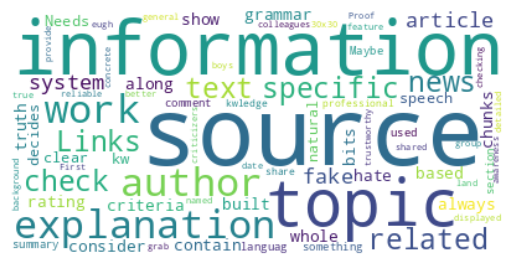

In [657]:

# Preprocess the text data
text_data = df_journos['ai-system-evaluation.additional-functionality'].dropna().str.cat(sep=' ')
text_data = re.sub(r'\b\w{1,3}\b', '', text_data)  # Remove short words (adjust the threshold as needed)

# Remove the specified phrases
ignore_phrases = ['no idea', 'No idea', 'not sure', 'Not sure', 'idea', 'sure', 'not', 'no']
for phrase in ignore_phrases:
    text_data = text_data.replace(phrase, '')

# Create the word cloud
wordcloud = WordCloud(background_color='white').generate(text_data)

# Plot the word cloud#
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('/content/wordcloud-additional_functionality.png', dpi=300, bbox_inches='tight')
plt.show()


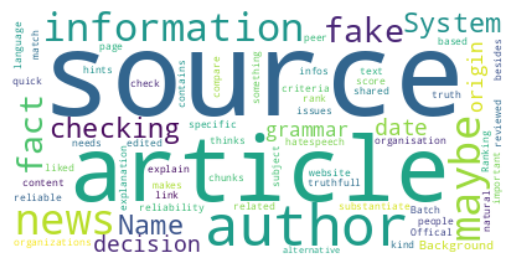

In [658]:
# Preprocess the text data
text_data = df_journos['ai-system-evaluation.other-information-wish'].dropna().str.cat(sep=' ')
text_data = re.sub(r'\b\w{1,3}\b', '', text_data)  # Remove short words (adjust the threshold as needed)

# Remove the specified phrases
ignore_phrases = ['no idea', 'No idea', 'not sure', 'Not sure', 'idea', 'sure', 'not', 'no']
for phrase in ignore_phrases:
    text_data = text_data.replace(phrase, '')

# Create the word cloud
wordcloud = WordCloud(background_color='white').generate(text_data)

# Plot the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('/content/wordcloud-better_access.png', dpi=300, bbox_inches='tight')
plt.show()


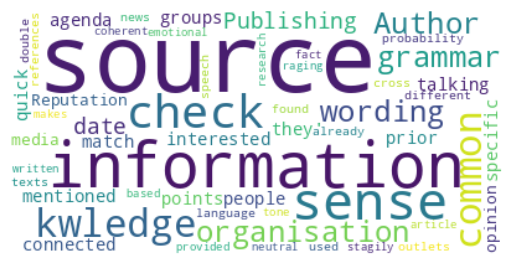

In [659]:
# Preprocess the text data
text_data = df_journos['ai-system-evaluation.criteria-to-judge-reliability'].dropna().str.cat(sep=' ')
text_data = re.sub(r'\b\w{1,3}\b', '', text_data)  # Remove short words (adjust the threshold as needed)

# Remove the specified phrases
ignore_phrases = ['no idea', 'No idea', 'not sure', 'Not sure', 'idea', 'sure', 'not', 'no']
for phrase in ignore_phrases:
    text_data = text_data.replace(phrase, '')

# Create the word cloud
wordcloud = WordCloud(background_color='white').generate(text_data)

# Plot the word cloud#
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig('/content/wordcloud-judge_reliability.png', dpi=300, bbox_inches='tight')
plt.show()


# Overall Scores

In [660]:
df['understandability_overall_global'].describe()


count    406.000000
mean       5.431034
std        1.166475
min        1.000000
25%        5.000000
50%        5.500000
75%        6.000000
max        7.000000
Name: understandability_overall_global, dtype: float64

In [661]:
df_journos['usefulness_overall_global'].describe()


count    27.000000
mean      5.401235
std       0.909658
min       2.333333
25%       4.916667
50%       5.666667
75%       6.000000
max       6.666667
Name: usefulness_overall_global, dtype: float64

In [662]:
df['information_literacy_overall'].describe()


count    406.000000
mean       5.724685
std        0.872924
min        1.666667
25%        5.222222
50%        5.888889
75%        6.333333
max        7.000000
Name: information_literacy_overall, dtype: float64

In [663]:

df_journos['expectations_after_ai_overall'].describe()

count    27.000000
mean      4.481481
std       0.950521
min       1.500000
25%       4.125000
50%       4.750000
75%       5.000000
max       5.750000
Name: expectations_after_ai_overall, dtype: float64